# Stacked histogram reading
## and extracting data / MC to get KL divergences

***
# Used packages
For plotting, calculating KL div
***

In [32]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
#plt.style.use([hep.style.ROOT, hep.style.fira, hep.style.firamath])
#plt.style.use([hep.style.ROOT, hep.style.firamath])

In [34]:
plt.style.use([hep.style.ROOT])

In [2]:
from scipy.stats import entropy

In [3]:
def kldiv(A, B):
        return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
    
def jsdiv(P, Q, normalize_first=False):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """
    
    P = np.array(P)
    Q = np.array(Q)

    if normalize_first:
        P = P/P.sum()
        Q = Q/Q.sum()
    
    M = 0.5 * (P + Q)

    return 0.5 * (kldiv(P, M) +kldiv(Q, M))

***
# Relevant final implementation starts here (update paths when necessary)
***

### Specify paths for different epochs
StackPlotter for three epochs or one epoch only results in slightly different directory names, but similar file names  
This is the place to add paths up to the point where they start to be similar again

In [4]:
ana_outdir_adv = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220809_2017_best_adversarial_eps0p01_/Plots_220809_best_adversarial_eps0p01_minimal_Custom']
ana_outdir_adv_dict = {'best':path for path in ana_outdir_adv}

In [5]:
ana_outdir_basic = ['/nfs/dust/cms/user/anstein/ctag_condor/systPlots_220811_2017_best_nominal_/Plots_220811_best_nominal_minimal_Custom']
ana_outdir_basic_dict = {'best':path for path in ana_outdir_basic}

Need to match the epochs with letters used

In [6]:
'''
epoch_letter_dict = {1: '_A_',
                    50: '_B_',
                    150:'_C_',
                     5: '_A_',
                    10: '_B_',
                    100:'_C_',
                    200:''}
'''
epoch_letter_dict = {1: '_A_',
                    50: '_B_',
                    150:'_C_',
                     5: '_A_',
                    10: '_B_',
                    100:'_C_',
                    'best':''}

### Calculate KL divergence for adversarial training

In [7]:
epochs = ['best']  # add the ones for which StackPlotter results exist
wms = ['DY_m', 'TT_semim', 'Wc_m']
# DY sel
kl_divs_all_adv_DY          = []
js_divs_all_adv_DY          = []
# Wc sel
kl_divs_all_adv_Wc          = []
js_divs_all_adv_Wc          = []
# TT sel
kl_divs_all_adv_TT          = []
js_divs_all_adv_TT          = []

kl_holder_adv = {'DY_m' : kl_divs_all_adv_DY, 'Wc_m' : kl_divs_all_adv_Wc, 'TT_semim' : kl_divs_all_adv_TT}
js_holder_adv = {'DY_m' : js_divs_all_adv_DY, 'Wc_m' : js_divs_all_adv_Wc, 'TT_semim' : js_divs_all_adv_TT}
#kl_divs_all_adv_DY_datadata = []
#kl_divs_all_adv_DY_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for j,wm in enumerate(wms):
    if wm == 'DY_m':
        indexjet = '0'
    else:
        indexjet = 'muJet_idx'
    for i,e in enumerate(epochs):
        kl_divs_adv          = []
        js_divs_adv          = []
        #kl_divs_adv_datadata = []
        #kl_divs_adv_simsim   = []
        for disc in ['BvsL', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
            if True:
                # data to MC
                #print(ana_outdir_adv_dict[e])
                histo = uproot.open(ana_outdir_adv_dict[e]+f'/output_2017_PFNano_central/{wm}_jet_Custom{epoch_letter_dict[e]}{disc}_{indexjet}_.root')

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                num_num, denom_num = num, denom
                #print(num, denom)
                denom[(denom == 0) & (num != 0)] = 0.00001
                where_num_or_denom_negative = (denom < 0) | (num < 0)
                num[where_num_or_denom_negative] = 0
                denom[where_num_or_denom_negative] = 0
                #print(num, denom)
                this_kl_a = entropy([v for v in num] , qk=[v for v in denom])
                kl_divs_adv.append(this_kl_a)

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                this_js = jsdiv(num, denom, normalize_first=True)

                js_divs_adv.append(this_js)

                '''
                # data / data and MC / MC
                #print(data_disc_histo_dict[disc])
                #print(data_disc_histo_dict)
                #print(disc)
                if i > 0:
                    # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                    data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                    where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                    num_num[where_num_or_denom_negative] = 0
                    data_disc_histo_dict[disc][where_num_or_denom_negative] = 0

                    # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                    sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                    where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                    denom_num[where_num_or_denom_negative] = 0
                    sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0


                    kl_divs_adv_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                    kl_divs_adv_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
                
                # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
                data_disc_histo_dict[disc] = num
                sim_disc_histo_dict[disc] = denom
                '''
            if False:
                kl_divs_adv.append(np.NaN)

        #print(kl_divs_adv)
        kl_holder_adv[wm].append(kl_divs_adv)
        js_holder_adv[wm].append(js_divs_adv)
        '''
        if i > 0:
            kl_divs_all_adv_DY_datadata.append(kl_divs_adv_datadata)
            kl_divs_all_adv_DY_simsim.append(kl_divs_adv_simsim)
        '''
    #kl_divs_all_adv_DY = np.array(kl_divs_all_adv_DY)
    #kl_divs_all_adv_DY_datadata = np.array(kl_divs_all_adv_DY_datadata)
    #kl_divs_all_adv_DY_simsim = np.array(kl_divs_all_adv_DY_simsim)

    print(kl_divs_all_adv_DY)
    print(js_divs_all_adv_DY)
    print(kl_divs_all_adv_Wc)
    print(js_divs_all_adv_Wc)
    print(kl_divs_all_adv_TT)
    print(js_divs_all_adv_TT)
    #print(kl_divs_all_adv_DY_datadata)
    #print(kl_divs_all_adv_DY_simsim)
    print()

/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[[0.0003162076285407905, 0.0002618340811234647, 0.002093140075118589]]
[[7.885368251880071e-05, 6.564102069817979e-05, 0.0005131025483467251]]
[]
[]
[]
[]

[[0.0003162076285407905, 0.0002618340811234647, 0.002093140075118589]]
[[7.885368251880071e-05, 6.564102069817979e-05, 0.0005131025483467251]]
[]
[]
[[0.013792773725514448, 0.012216403075984188, 0.011878707913406242]]
[[0.003397202926252344, 0.003030762794752921, 0.002925235225645132]]

[[0.0003162076285407905, 0.0002618340811234647, 0.002093140075118589]]
[[7.885368251880071e-05, 6.564102069817979e-05, 0.0005131025483467251]]
[[0.009351545586202997, 0.012116603736783343, 0.010938376646303077]]
[[0.002357215857789801, 0.0030695746502634874, 0.0027376109699653213]]
[[0.013792773725514448, 0.012216403075984188, 0.011878707913406242]]
[[0.003397202926252344, 0.003030762794752921, 0.002925235225645132]]



In [8]:
epochs = ['best']  # add the ones for which StackPlotter results exist
wms = ['DY_m', 'TT_semim', 'Wc_m']
# DY sel
kl_divs_all_basic_DY          = []
js_divs_all_basic_DY          = []
# Wc sel
kl_divs_all_basic_Wc          = []
js_divs_all_basic_Wc          = []
# TT sel
kl_divs_all_basic_TT          = []
js_divs_all_basic_TT          = []

kl_holder_basic = {'DY_m' : kl_divs_all_basic_DY, 'Wc_m' : kl_divs_all_basic_Wc, 'TT_semim' : kl_divs_all_basic_TT}
js_holder_basic = {'DY_m' : js_divs_all_basic_DY, 'Wc_m' : js_divs_all_basic_Wc, 'TT_semim' : js_divs_all_basic_TT}
#kl_divs_all_basic_DY_datadata = []
#kl_divs_all_basic_DY_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for j,wm in enumerate(wms):
    if wm == 'DY_m':
        indexjet = '0'
    else:
        indexjet = 'muJet_idx'
    for i,e in enumerate(epochs):
        kl_divs_basic          = []
        js_divs_basic          = []
        #kl_divs_basic_datadata = []
        #kl_divs_basic_simsim   = []
        for disc in ['BvsL', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
            if True:
                # data to MC
                #print(ana_outdir_basic_dict[e])
                histo = uproot.open(ana_outdir_basic_dict[e]+f'/output_2017_PFNano_central/{wm}_jet_Custom{epoch_letter_dict[e]}{disc}_{indexjet}_.root')

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                num_num, denom_num = num, denom
                #print(num, denom)
                denom[(denom == 0) & (num != 0)] = 0.00001
                where_num_or_denom_negative = (denom < 0) | (num < 0)
                num[where_num_or_denom_negative] = 0
                denom[where_num_or_denom_negative] = 0
                #print(num, denom)
                this_kl_a = entropy([v for v in num] , qk=[v for v in denom])
                kl_divs_basic.append(this_kl_a)

                num, denom = histo['Data'].values(), histo['MCSum'].values()
                this_js = jsdiv(num, denom, normalize_first=True)

                js_divs_basic.append(this_js)

                '''
                # data / data and MC / MC
                #print(data_disc_histo_dict[disc])
                #print(data_disc_histo_dict)
                #print(disc)
                if i > 0:
                    # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                    data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                    where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                    num_num[where_num_or_denom_negative] = 0
                    data_disc_histo_dict[disc][where_num_or_denom_negative] = 0

                    # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                    sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                    where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                    denom_num[where_num_or_denom_negative] = 0
                    sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0


                    kl_divs_basic_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                    kl_divs_basic_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
                
                # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
                data_disc_histo_dict[disc] = num
                sim_disc_histo_dict[disc] = denom
                '''
            if False:
                kl_divs_basic.append(np.NaN)

        #print(kl_divs_basic)
        kl_holder_basic[wm].append(kl_divs_basic)
        js_holder_basic[wm].append(js_divs_basic)
        '''
        if i > 0:
            kl_divs_all_basic_DY_datadata.append(kl_divs_basic_datadata)
            kl_divs_all_basic_DY_simsim.append(kl_divs_basic_simsim)
        '''
    #kl_divs_all_basic_DY = np.array(kl_divs_all_basic_DY)
    #kl_divs_all_basic_DY_datadata = np.array(kl_divs_all_basic_DY_datadata)
    #kl_divs_all_basic_DY_simsim = np.array(kl_divs_all_basic_DY_simsim)

    print(kl_divs_all_basic_DY)
    print(js_divs_all_basic_DY)
    print(kl_divs_all_basic_Wc)
    print(js_divs_all_basic_Wc)
    print(kl_divs_all_basic_TT)
    print(js_divs_all_basic_TT)
    #print(kl_divs_all_basic_DY_datadata)
    #print(kl_divs_all_basic_DY_simsim)
    print()

/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/afs/desy.de/user/a/anstein/miniconda3/envs/coffea-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


[[0.0020066627352019386, 0.0014977154275539, 0.00451826923300829]]
[[0.0005005244471849835, 0.0003753768869142394, 0.0011330457164203797]]
[]
[]
[]
[]

[[0.0020066627352019386, 0.0014977154275539, 0.00451826923300829]]
[[0.0005005244471849835, 0.0003753768869142394, 0.0011330457164203797]]
[]
[]
[[0.014673853219380445, 0.010429807971242298, 0.019769325174555735]]
[[0.0036133639262310724, 0.0025755197512220213, 0.004956031359290992]]

[[0.0020066627352019386, 0.0014977154275539, 0.00451826923300829]]
[[0.0005005244471849835, 0.0003753768869142394, 0.0011330457164203797]]
[[0.013424937961001988, 0.015843540885123936, 0.013571219649448605]]
[[0.003396501901490552, 0.0038317954312395057, 0.0034130196443714397]]
[[0.014673853219380445, 0.010429807971242298, 0.019769325174555735]]
[[0.0036133639262310724, 0.0025755197512220213, 0.004956031359290992]]



In [78]:
#xses = ['BvsL', 'BvsC', 'CvsB', 'CvsL']

In [9]:
xses = ['BvsL', 'CvsB', 'CvsL']

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

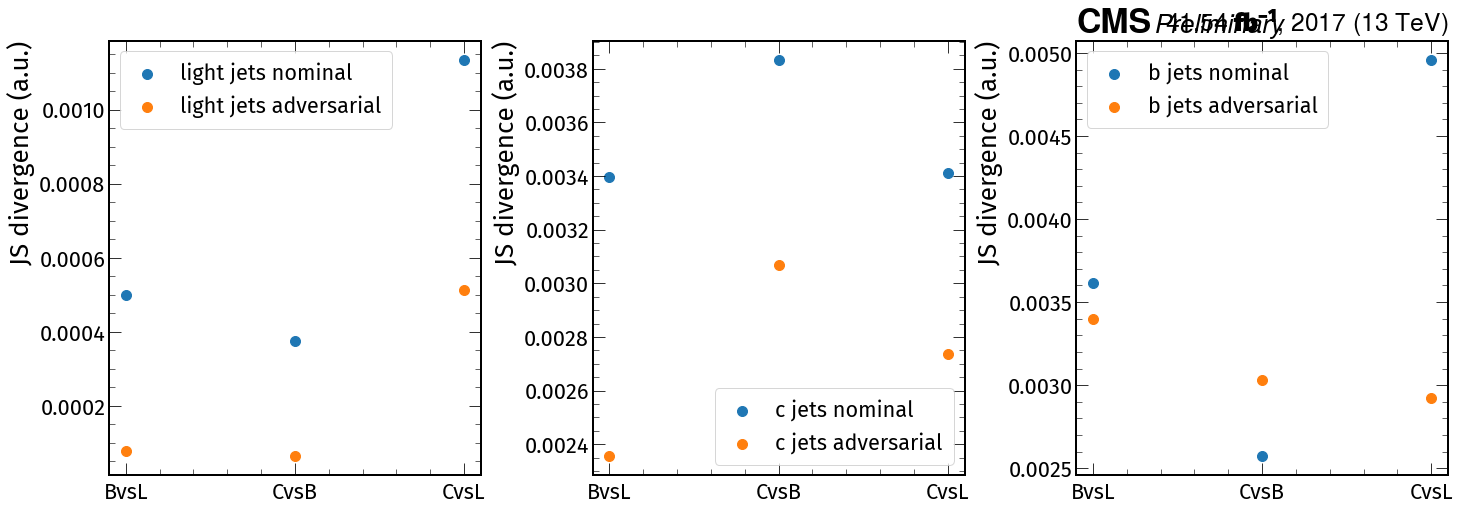

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
ax1.legend(frameon=True)
ax2.legend(frameon=True)
ax3.legend(frameon=True)
ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.54, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
#fig.savefig('js_best_epoch_custom_DeepJet_forRTG.pdf')

In [70]:
plt.rcParams['axes.axisbelow'] = True

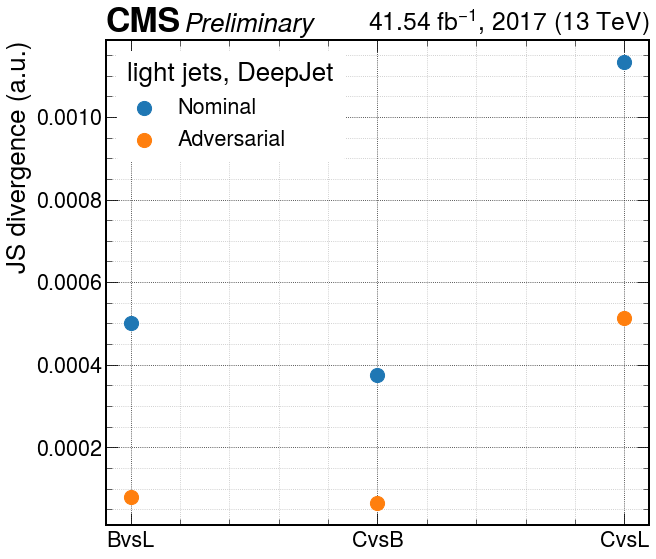

In [86]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax1 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax1.grid(which='minor', alpha=0.85)
ax1.grid(which='major', alpha=0.95, color='black')
ax1.scatter(xses, js_divs_all_basic_DY, label='Nominal'   , s=200 )
ax1.scatter(xses, js_divs_all_adv_DY, label='Adversarial' , s=200 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True, title='Light jets')
ax1.legend(frameon=True, framealpha=1, title='light jets, DeepJet')
leg = ax1.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax2.legend(frameon=True)
#ax3.legend(frameon=True)
ax1.set_ylabel('JS divergence (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.54, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
fig.savefig('js_best_epoch_custom_DeepJet_LIGHT_v2.pdf', bbox_inches='tight')

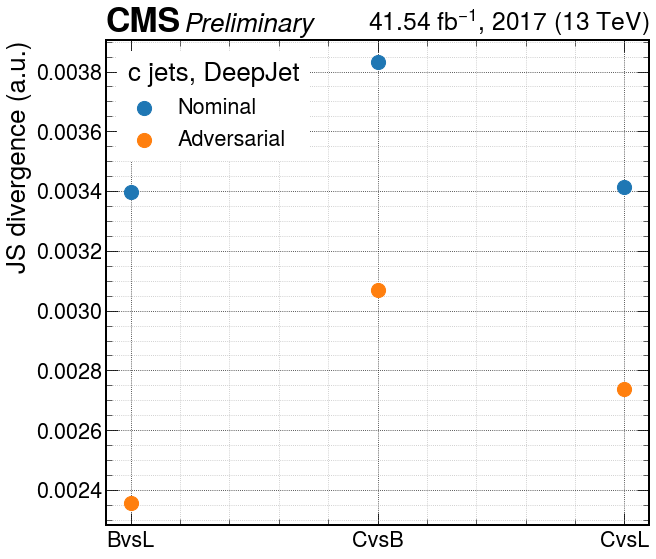

In [87]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax2 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax2.grid(which='minor', alpha=0.85)
ax2.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
ax2.scatter(xses, js_divs_all_basic_Wc, label='Nominal'       , s=200 )
ax2.scatter(xses, js_divs_all_adv_Wc, label='Adversarial'     , s=200 )
#ax3.scatter(xses, js_divs_all_basic_TT, label='b jets nominal'       , s=100 )
#ax3.scatter(xses, js_divs_all_adv_TT, label='b jets adversarial'     , s=100 )
#ax1.legend(frameon=True)
ax2.legend(frameon=True, framealpha=1, title='c jets, DeepJet', loc="upper left")
leg = ax2.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax3.legend(frameon=True)
#ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
#ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.54, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
fig.savefig('js_best_epoch_custom_DeepJet_CHARM_v2.pdf', bbox_inches='tight')

In [ ]:
#fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
fig, ax3 = plt.subplots(1, figsize=(9,8))
#fig.subplots_adjust(wspace = 0.3)
fig.tight_layout()
ax3.grid(which='minor', alpha=0.85)
ax3.grid(which='major', alpha=0.95, color='black')
#ax1.scatter(xses, js_divs_all_basic_DY, label='light jets nominal'   , s=100 )
#ax1.scatter(xses, js_divs_all_adv_DY, label='light jets adversarial' , s=100 )
#ax2.scatter(xses, js_divs_all_basic_Wc, label='c jets nominal'       , s=100 )
#ax2.scatter(xses, js_divs_all_adv_Wc, label='c jets adversarial'     , s=100 )
ax3.scatter(xses, js_divs_all_basic_TT, label='Nominal'       , s=200 )
ax3.scatter(xses, js_divs_all_adv_TT, label='Adversarial'     , s=200 )
#ax1.legend(frameon=True)
#ax2.legend(frameon=True)
ax3.legend(frameon=True, framealpha=1, title='b jets, DeepJet')
leg = ax3.get_legend()
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(0.0)
#ax1.set_ylabel('JS divergence (a.u.)')
#ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
hep.cms.label('Preliminary', data=True, lumi=41.54, year=2017)###fig.suptitle('JS divergence. Best epoch.', y=0.95)
fig.savefig('js_best_epoch_custom_DeepJet_BOTTOM_v2.pdf', bbox_inches='tight')

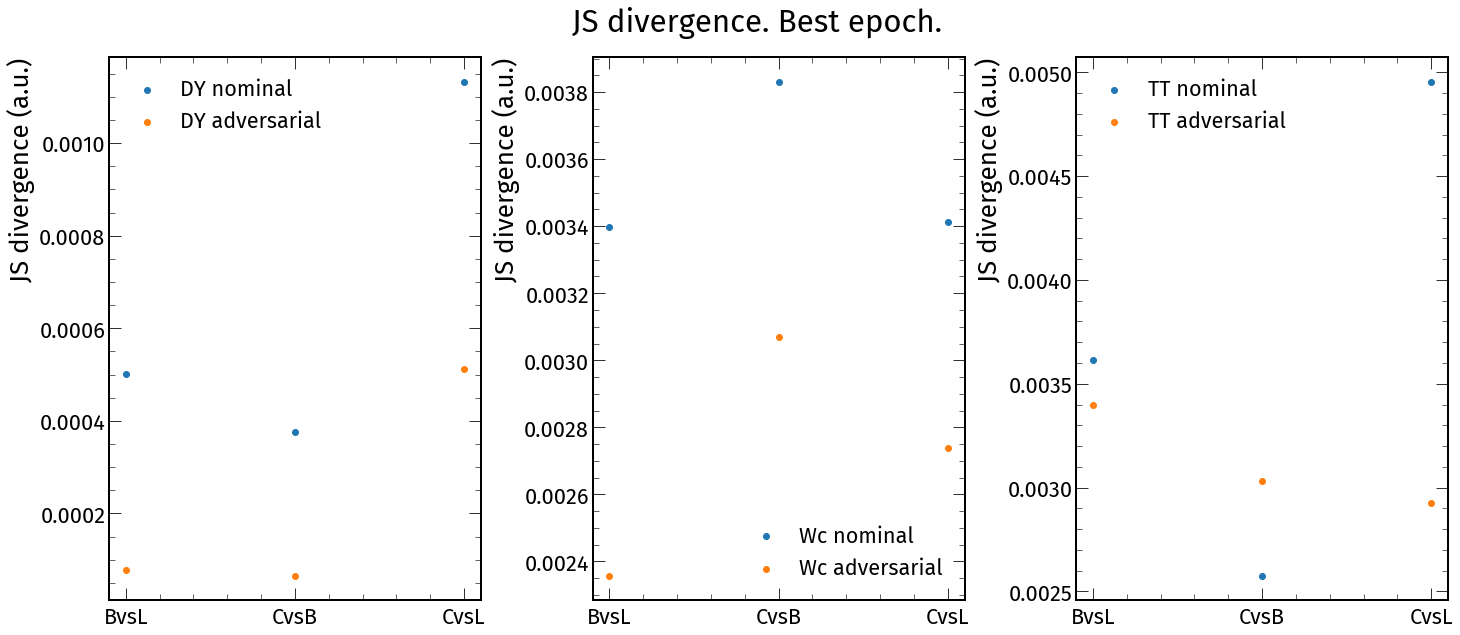

In [85]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,10))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, js_divs_all_basic_DY, label='DY nominal')
ax1.scatter(xses, js_divs_all_adv_DY, label='DY adversarial')
ax2.scatter(xses, js_divs_all_basic_Wc, label='Wc nominal')
ax2.scatter(xses, js_divs_all_adv_Wc, label='Wc adversarial')
ax3.scatter(xses, js_divs_all_basic_TT, label='TT nominal')
ax3.scatter(xses, js_divs_all_adv_TT, label='TT adversarial')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('JS divergence (a.u.)')
ax2.set_ylabel('JS divergence (a.u.)')
ax3.set_ylabel('JS divergence (a.u.)')
fig.suptitle('JS divergence. Best epoch.', y=0.95)
fig.savefig('js_best_epoch_custom_DeepJet.pdf')

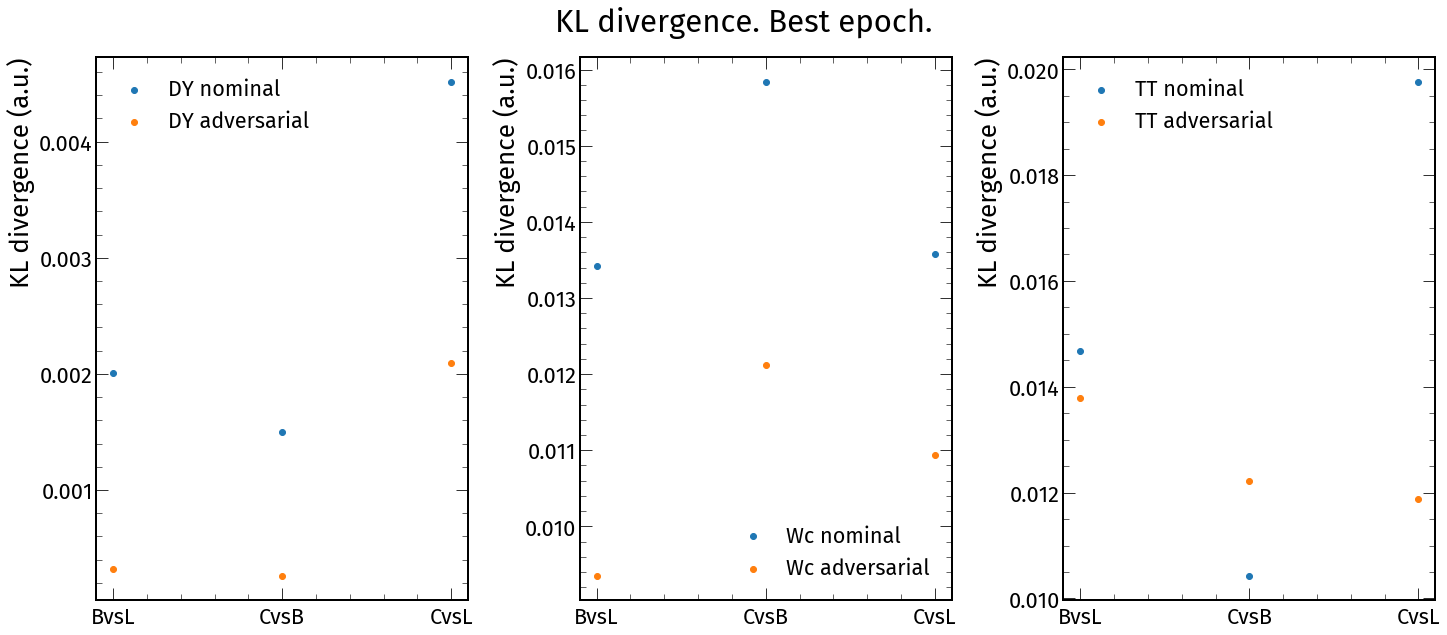

In [86]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,10))
fig.subplots_adjust(wspace = 0.3)
#fig.tight_layout()
ax1.scatter(xses, kl_divs_all_basic_DY, label='DY nominal')
ax1.scatter(xses, kl_divs_all_adv_DY, label='DY adversarial')
ax2.scatter(xses, kl_divs_all_basic_Wc, label='Wc nominal')
ax2.scatter(xses, kl_divs_all_adv_Wc, label='Wc adversarial')
ax3.scatter(xses, kl_divs_all_basic_TT, label='TT nominal')
ax3.scatter(xses, kl_divs_all_adv_TT, label='TT adversarial')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('KL divergence (a.u.)')
ax2.set_ylabel('KL divergence (a.u.)')
ax3.set_ylabel('KL divergence (a.u.)')
fig.suptitle('KL divergence. Best epoch.', y=0.95)
fig.savefig('kl_best_epoch_custom_DeepJet.pdf')

In [13]:
# Wc sel
kl_divs_all_adv_Wc          = []
kl_divs_all_adv_Wc_datadata = []
kl_divs_all_adv_Wc_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for i,e in enumerate(epochs):
    kl_divs_adv = []
    kl_divs_adv_datadata = []
    kl_divs_adv_simsim   = []
    for disc in ['Prob_b','Prob_bb','Prob_c','Prob_l','BvsL', 'BvsC', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
        try:
            histo = uproot.open(ana_outdir_adv_dict[e]+f'/output_2017_PFNano_central/Wc_m_jet_Custom{epoch_letter_dict[e]}{disc}_muJet_idx_.root')
            num, denom = histo['Data'].values(), histo['MCSum'].values()
            num_num, denom_num = num, denom
            #print(num, denom)
            denom[(denom == 0) & (num != 0)] = 0.00001
            where_num_or_denom_negative = (denom < 0) | (num < 0)
            num[where_num_or_denom_negative] = 0
            denom[where_num_or_denom_negative] = 0
            #print(num, denom)

            kl_divs_adv.append(entropy([v for v in num] , qk=[v for v in denom]))
            '''
            # data / data and MC / MC
            #print(data_disc_histo_dict[disc])
            #print(data_disc_histo_dict)
            #print(disc)
            if i > 0:
                # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                num_num[where_num_or_denom_negative] = 0
                data_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                denom_num[where_num_or_denom_negative] = 0
                sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                
                kl_divs_adv_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                kl_divs_adv_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
            '''
            # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
            data_disc_histo_dict[disc] = num
            sim_disc_histo_dict[disc] = denom
            
        except:
            kl_divs_adv.append(np.NaN)
            
    #print(kl_divs_adv)
    kl_divs_all_adv_Wc.append(kl_divs_adv)
    if i > 0:
        kl_divs_all_adv_Wc_datadata.append(kl_divs_adv_datadata)
        kl_divs_all_adv_Wc_simsim.append(kl_divs_adv_simsim)
    
kl_divs_all_adv_Wc = np.array(kl_divs_all_adv_Wc)
kl_divs_all_adv_Wc_datadata = np.array(kl_divs_all_adv_Wc_datadata)
kl_divs_all_adv_Wc_simsim = np.array(kl_divs_all_adv_Wc_simsim)

print(kl_divs_all_adv_Wc)
print(kl_divs_all_adv_Wc_datadata)
print(kl_divs_all_adv_Wc_simsim)
print()

# TTSEMILEP sel
kl_divs_all_adv_TT          = []
kl_divs_all_adv_TT_datadata = []
kl_divs_all_adv_TT_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
data_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
sim_disc_histo_dict = {'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for i,e in enumerate(epochs):
    kl_divs_adv = []
    kl_divs_adv_datadata = []
    kl_divs_adv_simsim   = []
    for disc in ['Prob_b','Prob_bb','Prob_c','Prob_l','BvsL', 'BvsC', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
        try:
            histo = uproot.open(ana_outdir_adv_dict[e]+f'/output_2017_PFNano_central/TT_semim_jet_Custom{epoch_letter_dict[e]}{disc}_muJet_idx_.root')
            num, denom = histo['Data'].values(), histo['MCSum'].values()
            num_num, denom_num = num, denom
            #print(num, denom)
            denom[(denom == 0) & (num != 0)] = 0.00001
            where_num_or_denom_negative = (denom < 0) | (num < 0)
            num[where_num_or_denom_negative] = 0
            denom[where_num_or_denom_negative] = 0
            #print(num, denom)

            kl_divs_adv.append(entropy([v for v in num] , qk=[v for v in denom]))
            '''
            # data / data and MC / MC
            #print(data_disc_histo_dict[disc])
            #print(data_disc_histo_dict)
            #print(disc)
            if i > 0:
                # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                num_num[where_num_or_denom_negative] = 0
                data_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                denom_num[where_num_or_denom_negative] = 0
                sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                
                kl_divs_adv_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                kl_divs_adv_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))
            '''
            # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
            data_disc_histo_dict[disc] = num
            sim_disc_histo_dict[disc] = denom
            
        except:
            kl_divs_adv.append(np.NaN)
            
    #print(kl_divs_adv)
    kl_divs_all_adv_TT.append(kl_divs_adv)
    if i > 0:
        kl_divs_all_adv_TT_datadata.append(kl_divs_adv_datadata)
        kl_divs_all_adv_TT_simsim.append(kl_divs_adv_simsim)
    
kl_divs_all_adv_TT = np.array(kl_divs_all_adv_TT)
kl_divs_all_adv_TT_datadata = np.array(kl_divs_all_adv_TT_datadata)
kl_divs_all_adv_TT_simsim = np.array(kl_divs_all_adv_TT_simsim)

print(kl_divs_all_adv_TT)
print(kl_divs_all_adv_TT_datadata)
print(kl_divs_all_adv_TT_simsim)

NameError: name 'kl_divs_all_adv_DY_datadata' is not defined

### Calculate KL divergence for basic training

In [9]:
epochs = [1,5,10,50,100,150,200]  # add the ones for which StackPlotter results exist
# DY sel
kl_divs_all_basic_DY          = []
kl_divs_all_basic_DY_datadata = []
kl_divs_all_basic_DY_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for i,e in enumerate(epochs):
    kl_divs_basic          = []
    kl_divs_basic_datadata = []
    kl_divs_basic_simsim   = []
    for disc in ['Prob_b','Prob_bb','Prob_c','Prob_l','BvsL', 'BvsC', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
        try:
            # data to MC
            histo = uproot.open(ana_outdir_basic_dict[e]+f'/output_2017_PFNano_central/DY_m_jet_Custom{epoch_letter_dict[e]}{disc}_0_.root')
            num, denom = histo['Data'].values(), histo['MCSum'].values()
            num_num, denom_num = num, denom
            #print(num, denom)
            denom[(denom == 0) & (num != 0)] = 0.00001
            where_num_or_denom_negative = (denom < 0) | (num < 0)
            num[where_num_or_denom_negative] = 0
            denom[where_num_or_denom_negative] = 0
            #print(num, denom)

            kl_divs_basic.append(entropy([v for v in num] , qk=[v for v in denom]))

            # data / data and MC / MC
            #print(data_disc_histo_dict[disc])
            #print(data_disc_histo_dict)
            #print(disc)
            if i > 0:
                # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                num_num[where_num_or_denom_negative] = 0
                data_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                denom_num[where_num_or_denom_negative] = 0
                sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                
                kl_divs_basic_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                kl_divs_basic_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))

            # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
            data_disc_histo_dict[disc] = num
            sim_disc_histo_dict[disc] = denom
            
        except:
            kl_divs_basic.append(np.NaN)
            
    #print(kl_divs_basic)
    kl_divs_all_basic_DY.append(kl_divs_basic)
    if i > 0:
        kl_divs_all_basic_DY_datadata.append(kl_divs_basic_datadata)
        kl_divs_all_basic_DY_simsim.append(kl_divs_basic_simsim)
    
kl_divs_all_basic_DY = np.array(kl_divs_all_basic_DY)
kl_divs_all_basic_DY_datadata = np.array(kl_divs_all_basic_DY_datadata)
kl_divs_all_basic_DY_simsim = np.array(kl_divs_all_basic_DY_simsim)

print(kl_divs_all_basic_DY)
print(kl_divs_all_basic_DY_datadata)
print(kl_divs_all_basic_DY_simsim)
print()
# Wc sel
kl_divs_all_basic_Wc          = []
kl_divs_all_basic_Wc_datadata = []
kl_divs_all_basic_Wc_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for i,e in enumerate(epochs):
    kl_divs_basic = []
    kl_divs_basic_datadata = []
    kl_divs_basic_simsim   = []
    for disc in ['Prob_b','Prob_bb','Prob_c','Prob_l','BvsL', 'BvsC', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
        try:
            histo = uproot.open(ana_outdir_basic_dict[e]+f'/output_2017_PFNano_central/Wc_m_jet_Custom{epoch_letter_dict[e]}{disc}_muJet_idx_.root')
            num, denom = histo['Data'].values(), histo['MCSum'].values()
            num_num, denom_num = num, denom
            #print(num, denom)
            denom[(denom == 0) & (num != 0)] = 0.00001
            where_num_or_denom_negative = (denom < 0) | (num < 0)
            num[where_num_or_denom_negative] = 0
            denom[where_num_or_denom_negative] = 0
            #print(num, denom)

            kl_divs_basic.append(entropy([v for v in num] , qk=[v for v in denom]))

            # data / data and MC / MC
            #print(data_disc_histo_dict[disc])
            #print(data_disc_histo_dict)
            #print(disc)
            if i > 0:
                # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                num_num[where_num_or_denom_negative] = 0
                data_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                denom_num[where_num_or_denom_negative] = 0
                sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                
                kl_divs_basic_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                kl_divs_basic_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))

            # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
            data_disc_histo_dict[disc] = num
            sim_disc_histo_dict[disc] = denom
            
        except:
            kl_divs_basic.append(np.NaN)
            
    #print(kl_divs_basic)
    kl_divs_all_basic_Wc.append(kl_divs_basic)
    if i > 0:
        kl_divs_all_basic_Wc_datadata.append(kl_divs_basic_datadata)
        kl_divs_all_basic_Wc_simsim.append(kl_divs_basic_simsim)
    
kl_divs_all_basic_Wc = np.array(kl_divs_all_basic_Wc)
kl_divs_all_basic_Wc_datadata = np.array(kl_divs_all_basic_Wc_datadata)
kl_divs_all_basic_Wc_simsim = np.array(kl_divs_all_basic_Wc_simsim)

print(kl_divs_all_basic_Wc)
print(kl_divs_all_basic_Wc_datadata)
print(kl_divs_all_basic_Wc_simsim)
print()

# TTSEMILEP sel
kl_divs_all_basic_TT          = []
kl_divs_all_basic_TT_datadata = []
kl_divs_all_basic_TT_simsim   = []
#data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
#sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
data_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
sim_disc_histo_dict = {'Prob_b':[],'Prob_bb':[],'Prob_c':[],'Prob_l':[],'BvsL':[], 'BvsC':[], 'CvsB':[], 'CvsL':[]}
for i,e in enumerate(epochs):
    kl_divs_basic = []
    kl_divs_basic_datadata = []
    kl_divs_basic_simsim   = []
    for disc in ['Prob_b','Prob_bb','Prob_c','Prob_l','BvsL', 'BvsC', 'CvsB', 'CvsL']:  # select those that exist for paths listed below
        try:
            histo = uproot.open(ana_outdir_basic_dict[e]+f'/output_2017_PFNano_central/TT_semim_jet_Custom{epoch_letter_dict[e]}{disc}_muJet_idx_.root')
            num, denom = histo['Data'].values(), histo['MCSum'].values()
            num_num, denom_num = num, denom
            #print(num, denom)
            denom[(denom == 0) & (num != 0)] = 0.00001
            where_num_or_denom_negative = (denom < 0) | (num < 0)
            num[where_num_or_denom_negative] = 0
            denom[where_num_or_denom_negative] = 0
            #print(num, denom)

            kl_divs_basic.append(entropy([v for v in num] , qk=[v for v in denom]))

            # data / data and MC / MC
            #print(data_disc_histo_dict[disc])
            #print(data_disc_histo_dict)
            #print(disc)
            if i > 0:
                # data / data (this epoch: num_num / previous epoch: look up in dictionary)                
                data_disc_histo_dict[disc][(data_disc_histo_dict[disc] == 0) & (num_num != 0)] = 0.00001
                where_num_or_denom_negative = (data_disc_histo_dict[disc] < 0) | (num_num < 0)
                num_num[where_num_or_denom_negative] = 0
                data_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                # mc / mc (this epoch: denom_num / previous epoch: look up in dictionary)                
                sim_disc_histo_dict[disc][(sim_disc_histo_dict[disc] == 0) & (denom_num != 0)] = 0.00001
                where_num_or_denom_negative = (sim_disc_histo_dict[disc] < 0) | (denom_num < 0)
                denom_num[where_num_or_denom_negative] = 0
                sim_disc_histo_dict[disc][where_num_or_denom_negative] = 0
                
                
                kl_divs_basic_datadata.append(entropy([v for v in num_num] , qk=data_disc_histo_dict[disc]))
                kl_divs_basic_simsim.append(entropy([v for v in denom_num] , qk=sim_disc_histo_dict[disc]))

            # store this epoch's histogram for the respective variable in the dictionary (makes comparing with previous epoch possible)
            data_disc_histo_dict[disc] = num
            sim_disc_histo_dict[disc] = denom
            
        except:
            kl_divs_basic.append(np.NaN)
            
    #print(kl_divs_basic)
    kl_divs_all_basic_TT.append(kl_divs_basic)
    if i > 0:
        kl_divs_all_basic_TT_datadata.append(kl_divs_basic_datadata)
        kl_divs_all_basic_TT_simsim.append(kl_divs_basic_simsim)
    
kl_divs_all_basic_TT = np.array(kl_divs_all_basic_TT)
kl_divs_all_basic_TT_datadata = np.array(kl_divs_all_basic_TT_datadata)
kl_divs_all_basic_TT_simsim = np.array(kl_divs_all_basic_TT_simsim)

print(kl_divs_all_basic_TT)
print(kl_divs_all_basic_TT_datadata)
print(kl_divs_all_basic_TT_simsim)

[[0.01217298 0.00320077 0.00489611 0.00975494 0.00882265 0.007753
  0.007753   0.01025109]
 [0.01846887 0.00707908 0.00805294 0.01861915 0.01633346 0.01373989
  0.01373986 0.01813654]
 [0.0203709  0.00733145 0.00926072 0.01940474 0.01766484 0.01512929
  0.01512924 0.01591823]
 [0.01827099 0.00708223 0.00856153 0.01931578 0.01723915 0.01449261
  0.01449246 0.01648307]
 [0.01736554 0.00741438 0.00875505 0.01914036 0.01684516 0.01406086
  0.01406092 0.01603358]
 [0.01646832 0.00687611 0.00820452 0.01833218 0.01599312 0.01324725
  0.01324723 0.01616311]
 [0.01653485 0.00671095 0.00791105 0.0183433  0.01589259 0.01313961
  0.01313959 0.01622523]]
[[4.65822516e-02 1.37895322e-01 9.47938238e-02 5.60530533e-02
  6.29999810e-02 7.33209085e-02 7.33210563e-02 1.19880545e-01]
 [1.33718198e-02 1.96101722e-02 9.12332817e-02 1.02094735e-02
  1.77495982e-02 2.43159879e-02 2.43161063e-02 1.66791849e-02]
 [2.08663091e-03 1.32502175e-02 1.02300752e-02 5.13045683e-03
  6.27174129e-03 8.28422549e-03 8.2843

***
## Data versus Simulation

### Plot KL div for adversarial training

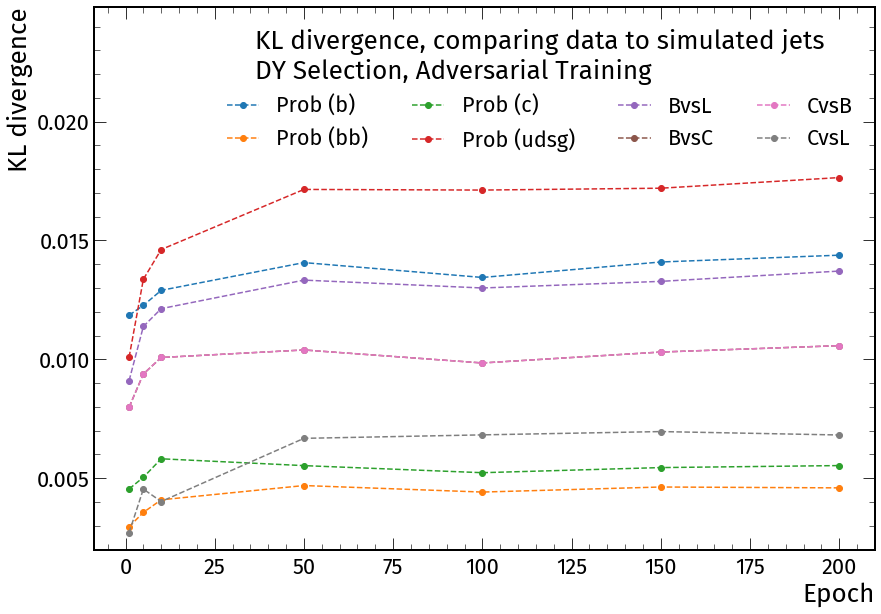

In [214]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_adv_DY[:,0],'o--',label='Prob (b)')
ax.plot(epochs, kl_divs_all_adv_DY[:,1],'o--',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_adv_DY[:,2],'o--',label='Prob (c)')
ax.plot(epochs, kl_divs_all_adv_DY[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_adv_DY[:,4],'o--',label='BvsL')
ax.plot(epochs, kl_divs_all_adv_DY[:,5],'o--',label='BvsC')
ax.plot(epochs, kl_divs_all_adv_DY[:,6],'o--',label='CvsB')
ax.plot(epochs, kl_divs_all_adv_DY[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nDY Selection, Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.35*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n DY Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_DY.svg', bbox_inches='tight')

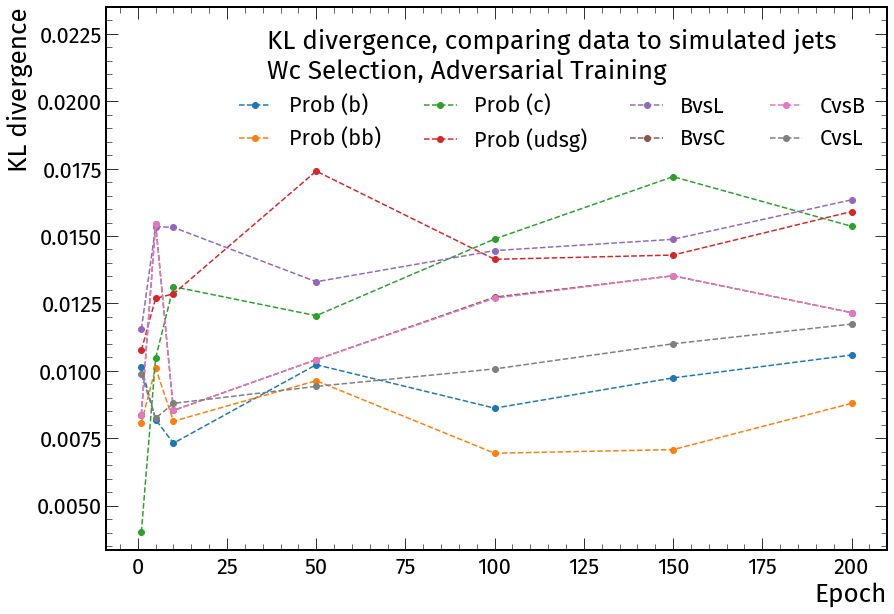

In [216]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_adv_Wc[:,0],'o--',label='Prob (b)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,1],'o--',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,2],'o--',label='Prob (c)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,4],'o--',label='BvsL')
ax.plot(epochs, kl_divs_all_adv_Wc[:,5],'o--',label='BvsC')
ax.plot(epochs, kl_divs_all_adv_Wc[:,6],'o--',label='CvsB')
ax.plot(epochs, kl_divs_all_adv_Wc[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nWc Selection, Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Wc Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_Wc.svg', bbox_inches='tight')

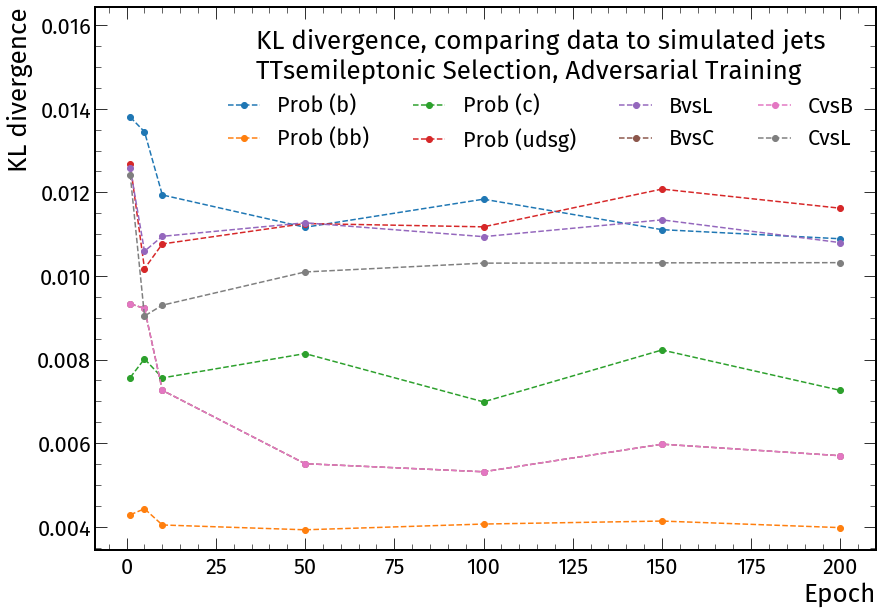

In [207]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_adv_TT[:,0],'o--',label='Prob (b)')
ax.plot(epochs, kl_divs_all_adv_TT[:,1],'o--',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_adv_TT[:,2],'o--',label='Prob (c)')
ax.plot(epochs, kl_divs_all_adv_TT[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_adv_TT[:,4],'o--',label='BvsL')
ax.plot(epochs, kl_divs_all_adv_TT[:,5],'o--',label='BvsC')
ax.plot(epochs, kl_divs_all_adv_TT[:,6],'o--',label='CvsB')
ax.plot(epochs, kl_divs_all_adv_TT[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nTTsemileptonic Selection, Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.15*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n TTsemileptonic Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_TT.svg', bbox_inches='tight')

### Plot KL div for basic training

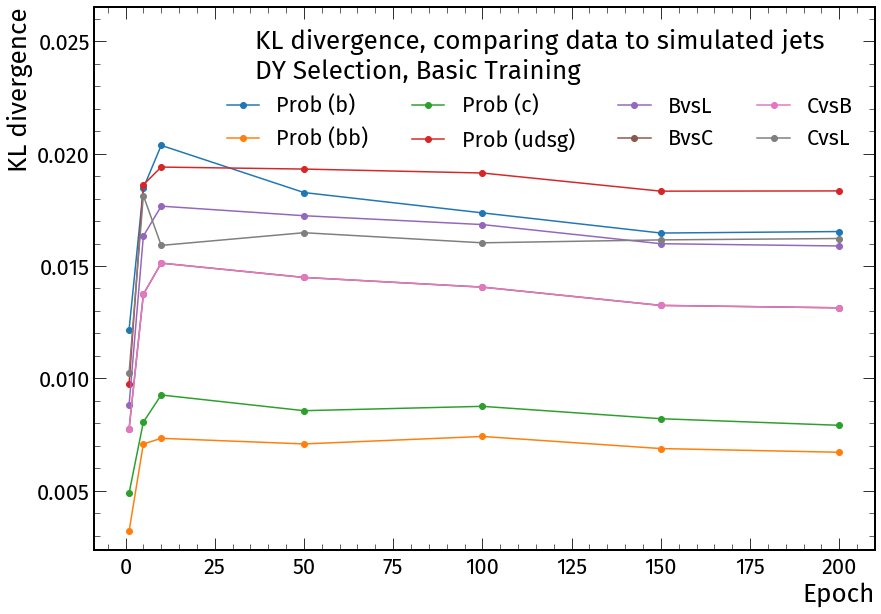

In [206]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,0],'o-',label='Prob (b)')
ax.plot(epochs, kl_divs_all_basic_DY[:,1],'o-',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_basic_DY[:,2],'o-',label='Prob (c)')
ax.plot(epochs, kl_divs_all_basic_DY[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_basic_DY[:,4],'o-',label='BvsL')
ax.plot(epochs, kl_divs_all_basic_DY[:,5],'o-',label='BvsC')
ax.plot(epochs, kl_divs_all_basic_DY[:,6],'o-',label='CvsB')
ax.plot(epochs, kl_divs_all_basic_DY[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nDY Selection, Basic Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.25*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n DY Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_DY.svg', bbox_inches='tight')

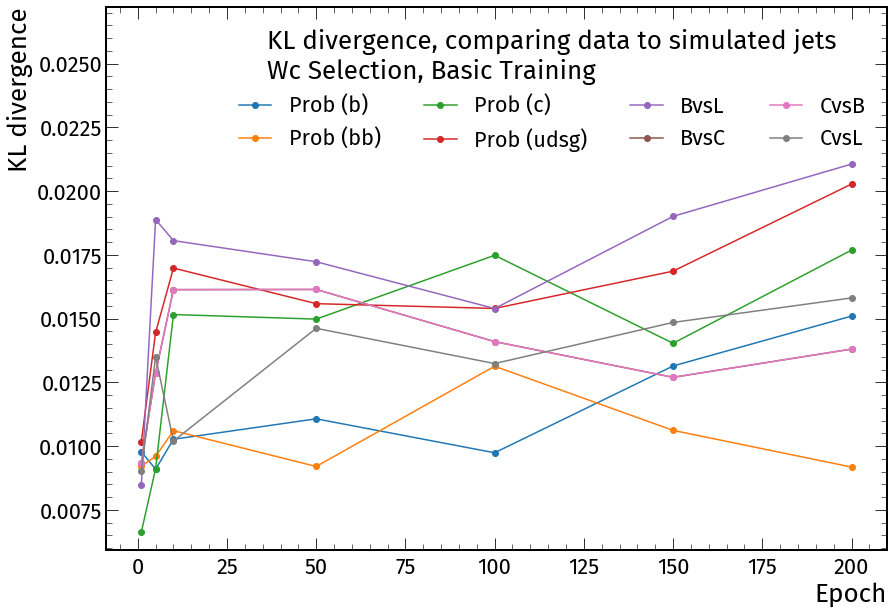

In [204]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,0],'o-',label='Prob (b)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,1],'o-',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,2],'o-',label='Prob (c)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,4],'o-',label='BvsL')
ax.plot(epochs, kl_divs_all_basic_Wc[:,5],'o-',label='BvsC')
ax.plot(epochs, kl_divs_all_basic_Wc[:,6],'o-',label='CvsB')
ax.plot(epochs, kl_divs_all_basic_Wc[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nWc Selection, Basic Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.25*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Wc Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_Wc.svg', bbox_inches='tight')

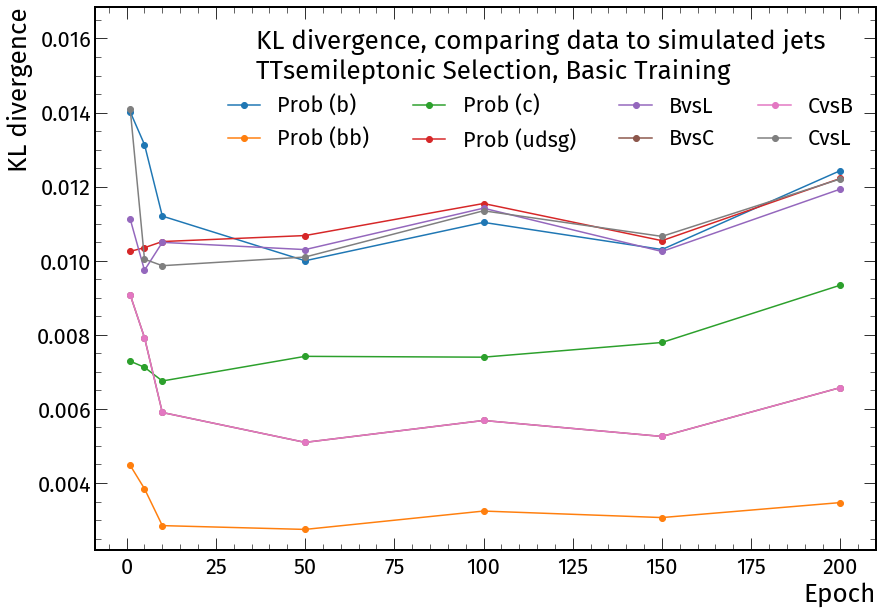

In [202]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,0],'o-',label='Prob (b)')
ax.plot(epochs, kl_divs_all_basic_TT[:,1],'o-',label='Prob (bb)')
ax.plot(epochs, kl_divs_all_basic_TT[:,2],'o-',label='Prob (c)')
ax.plot(epochs, kl_divs_all_basic_TT[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs, kl_divs_all_basic_TT[:,4],'o-',label='BvsL')
ax.plot(epochs, kl_divs_all_basic_TT[:,5],'o-',label='BvsC')
ax.plot(epochs, kl_divs_all_basic_TT[:,6],'o-',label='CvsB')
ax.plot(epochs, kl_divs_all_basic_TT[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to simulated jets\nTTsemileptonic Selection, Basic Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.15*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n TTsemileptonic Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_TT.svg', bbox_inches='tight')

### Compare KL divergence for basic or adversarial training

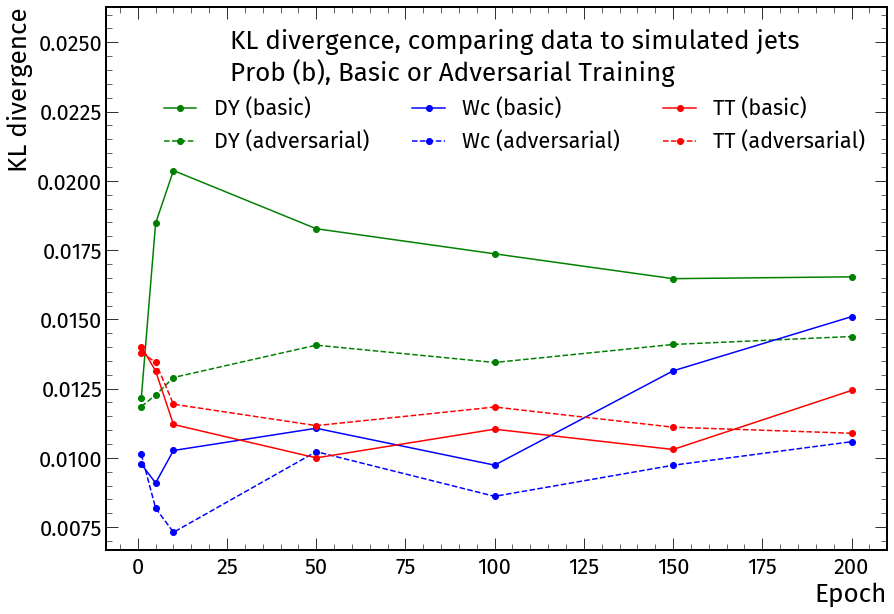

In [201]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,0], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,0],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,0], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,0],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,0], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nProb (b), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.25*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Prob (b), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b.svg', bbox_inches='tight')

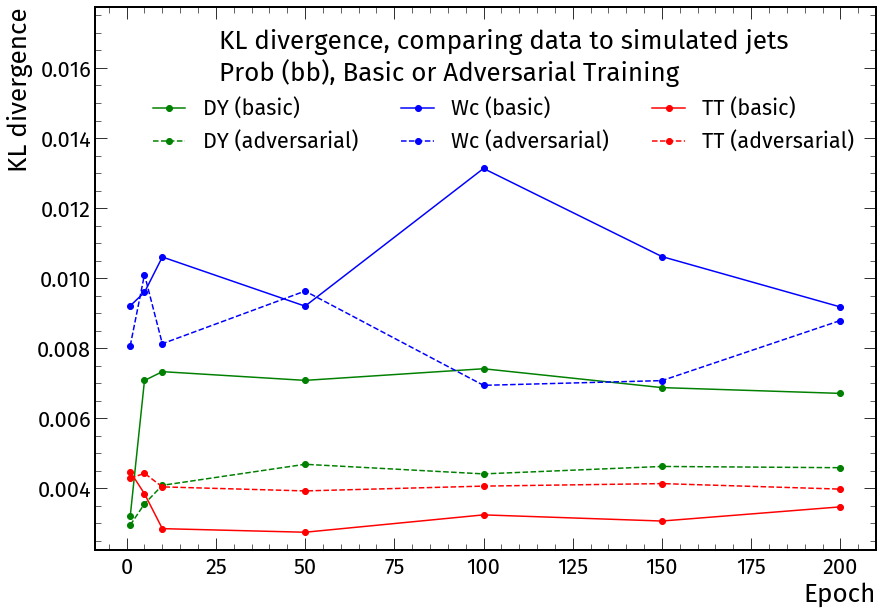

In [199]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,1], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,1],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,1], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,1],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,1], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nProb (bb), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Prob (bb), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb.svg', bbox_inches='tight')

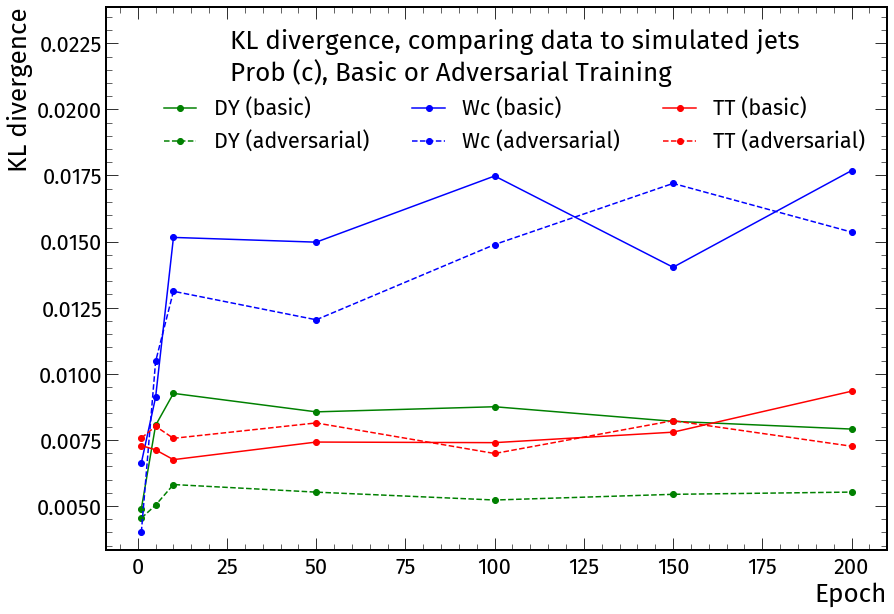

In [196]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,2], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,2],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,2], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,2],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,2], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nProb (c), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Prob (c), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c.svg', bbox_inches='tight')

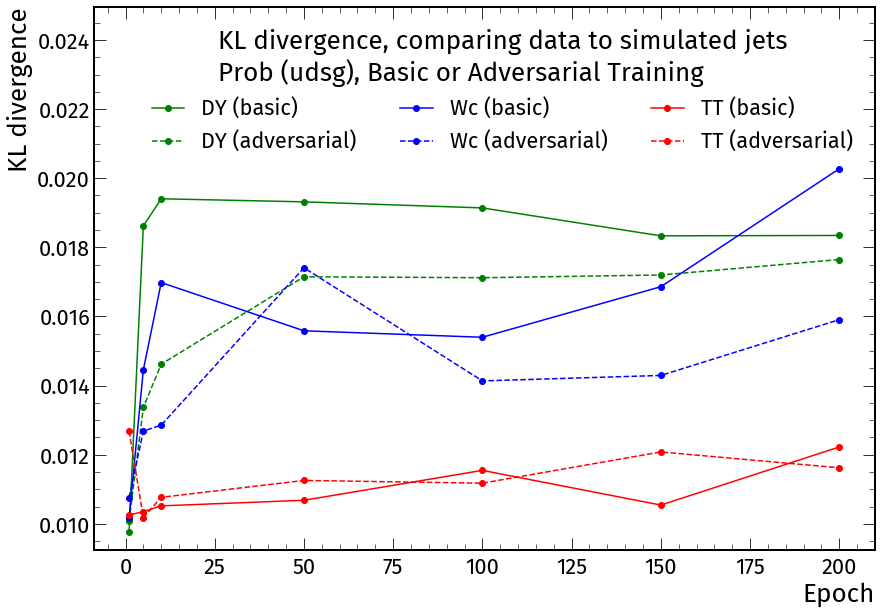

In [193]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,3], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,3],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,3], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,3],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,3], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nProb (udsg), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.2*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n Prob (udsg), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg.svg', bbox_inches='tight')

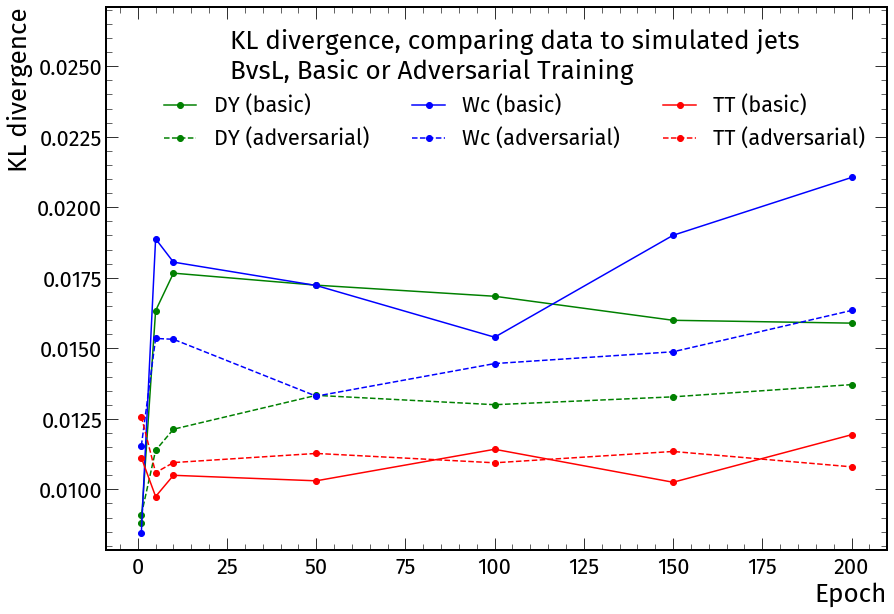

In [190]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,4], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,4],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,4], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,4],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,4], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nBvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.25*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n BvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL.svg', bbox_inches='tight')

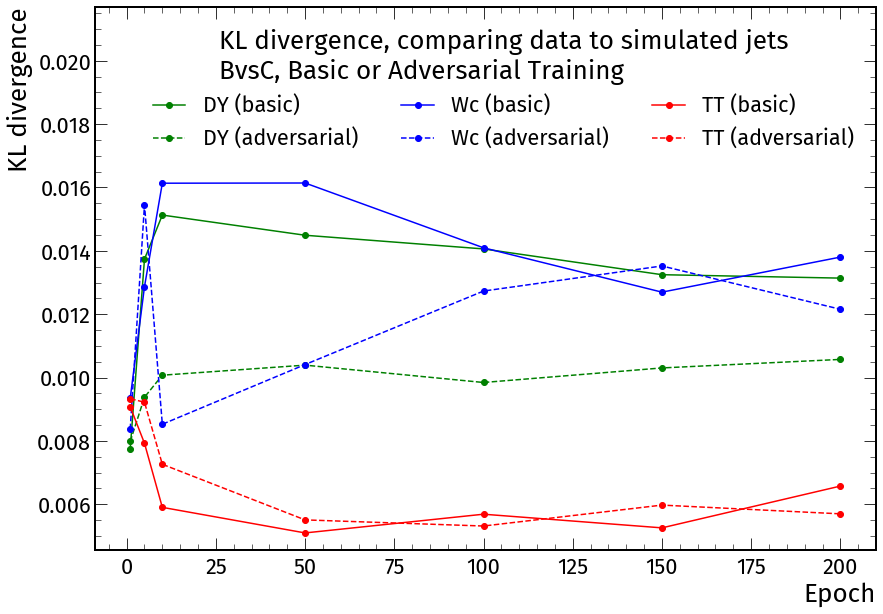

In [188]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,5], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,5],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,5], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,5],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,5], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nBvsC, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n BvsC, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC.svg', bbox_inches='tight')

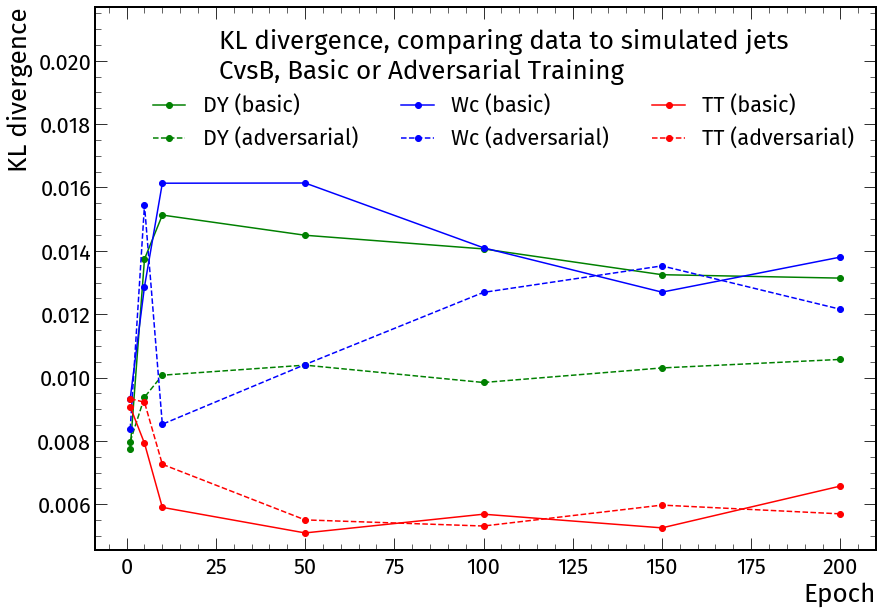

In [187]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,6], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,6],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,6], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,6],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,6], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nCvsB, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n CvsB, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB.svg', bbox_inches='tight')

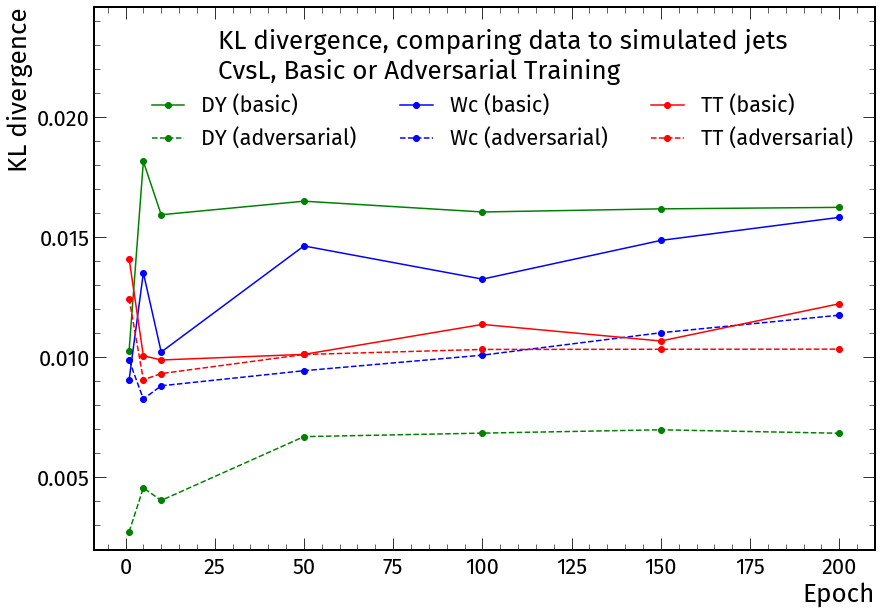

In [185]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,7], 'o-g', label='DY (basic)')
ax.plot(epochs, kl_divs_all_adv_DY[:,7],  'o--g', label='DY (adversarial)')
ax.plot(epochs, kl_divs_all_basic_Wc[:,7], 'o-b', label='Wc (basic)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,7],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs, kl_divs_all_basic_TT[:,7], 'o-r', label='TT (basic)')
ax.plot(epochs, kl_divs_all_adv_TT[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,title='KL divergence, comparing data to simulated jets\nCvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
#print(y_lims)
ax.set_ylim(min(y_lims),1.3*max(y_lims))
#fig.suptitle('KL divergence, comparing data to simulated jets\n CvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsL.svg', bbox_inches='tight')

***
## Data versus Data

### Plot KL div for adversarial training

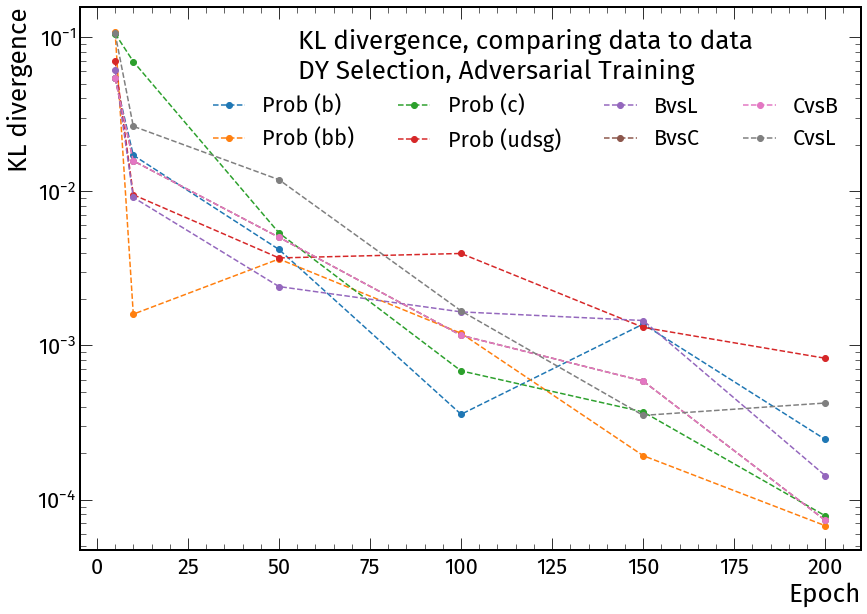

In [181]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nDY Selection, Adversarial Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.05*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n DY Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_DY_datadata.svg', bbox_inches='tight')

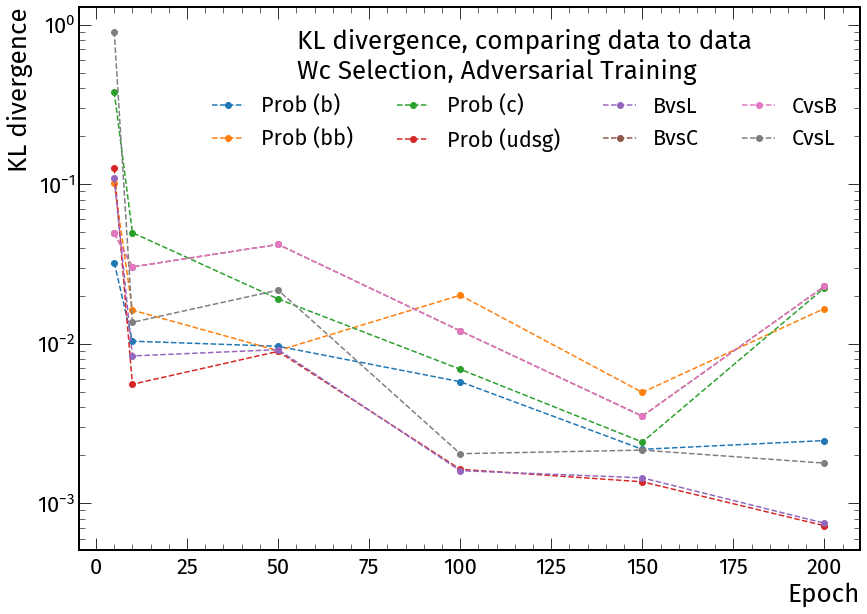

In [180]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nWc Selection, Adversarial Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.05*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Wc Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_Wc_datadata.svg', bbox_inches='tight')

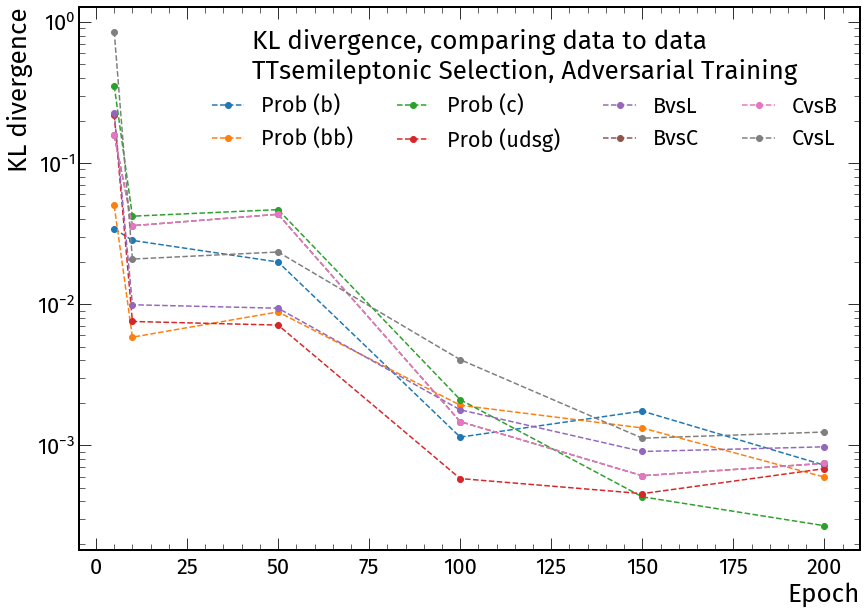

In [179]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nTTsemileptonic Selection, Adversarial Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n TTsemileptonic Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_TT_datadata.svg', bbox_inches='tight')

### Plot KL div for basic training

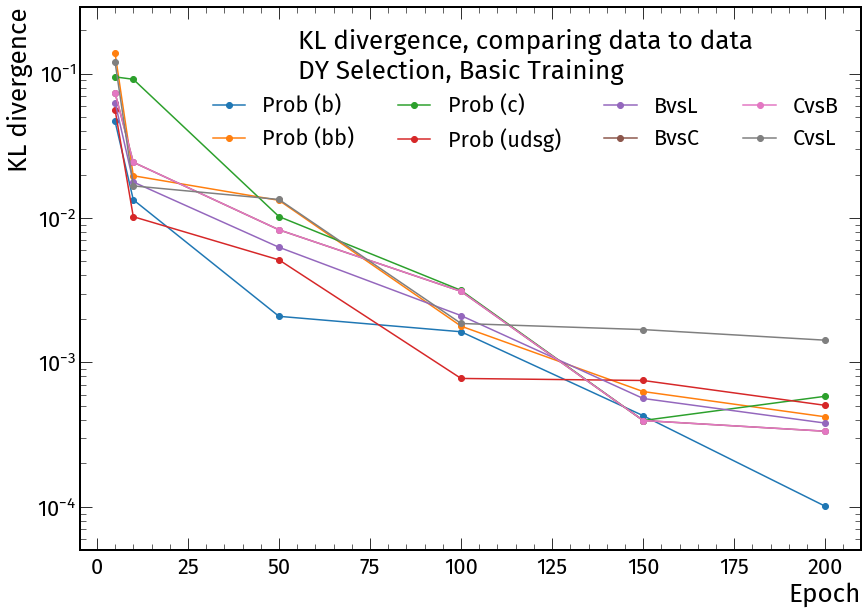

In [178]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nDY Selection, Basic Training')
y_lims = ax.get_ylim()
ax.set_ylim(5e-5,2*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n DY Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_DY_datadata.svg', bbox_inches='tight')

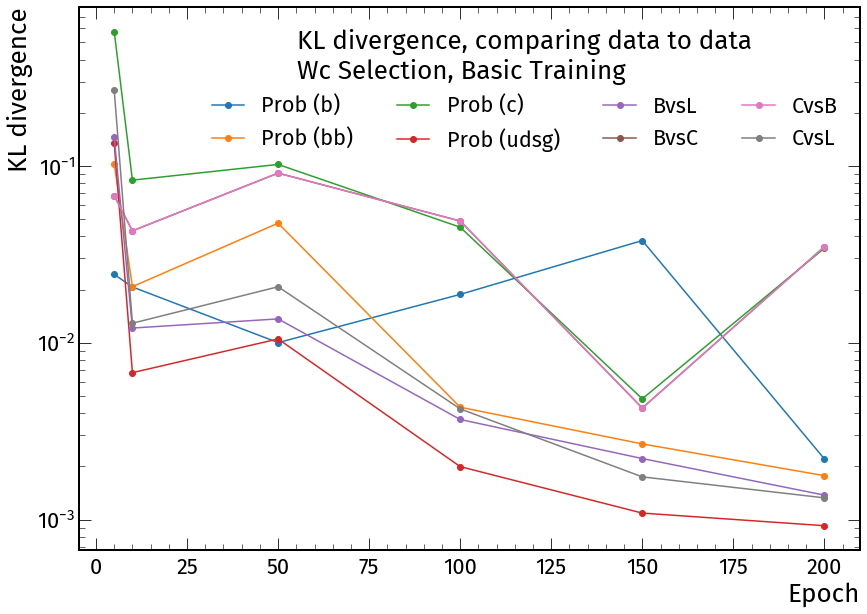

In [171]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nWc Selection, Basic Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Wc Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_Wc_datadata.svg', bbox_inches='tight')

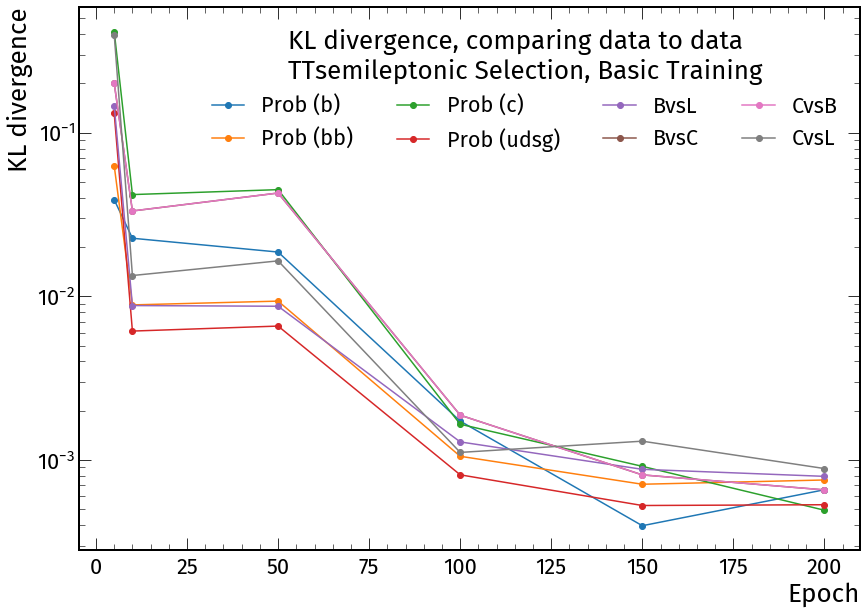

In [170]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing data to data\nTTsemileptonic Selection, Basic Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n TTsemileptonic Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_TT_datadata.svg', bbox_inches='tight')

### Compare KL divergence for basic or adversarial training

(-0.002623770048016136, 0.0573224943265414)


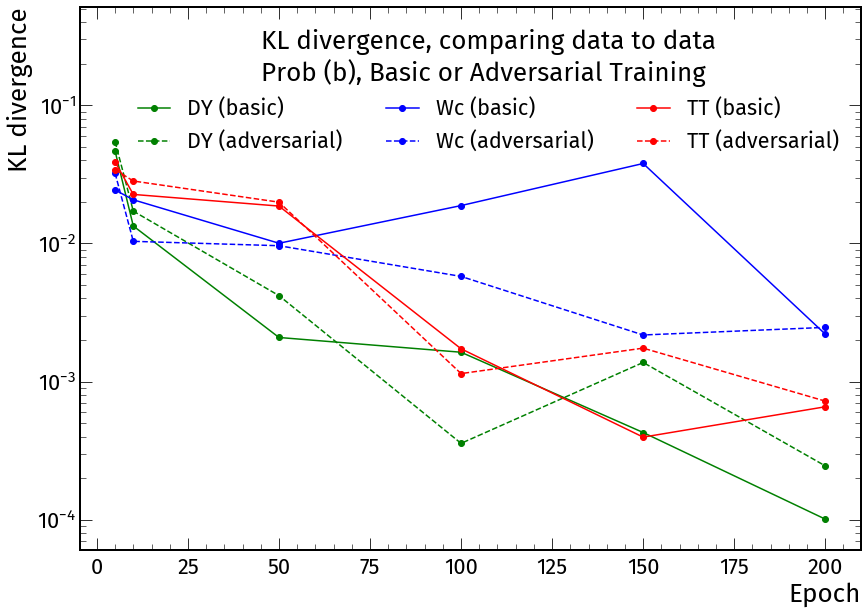

In [169]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,0], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,0],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,0], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,0],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,0], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nProb (b), Basic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=6e-5,top=9*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Prob (b), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b_datadata.svg', bbox_inches='tight')

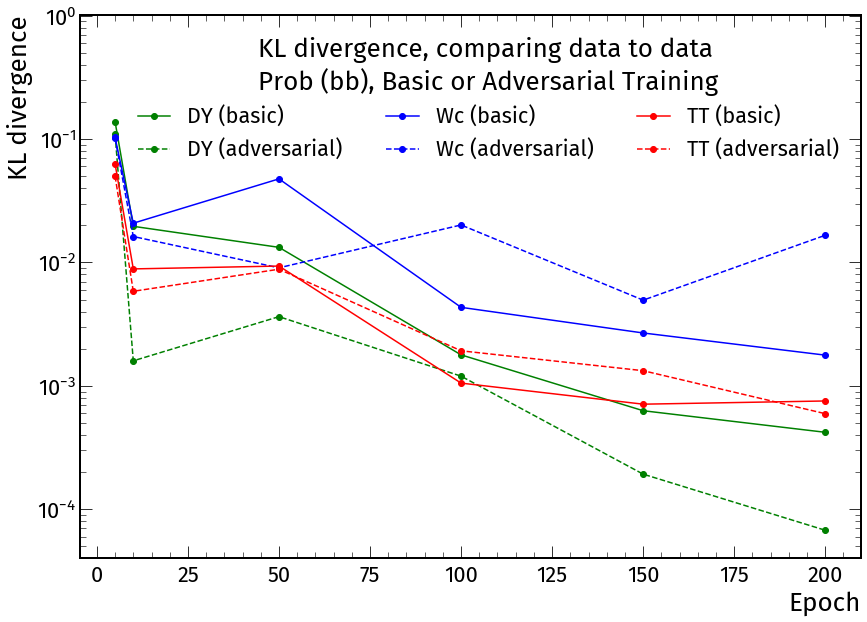

In [167]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,1], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,1],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,1], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,1],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,1], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nProb (bb), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=4e-5,top=7*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Prob (bb), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb_datadata.svg', bbox_inches='tight')

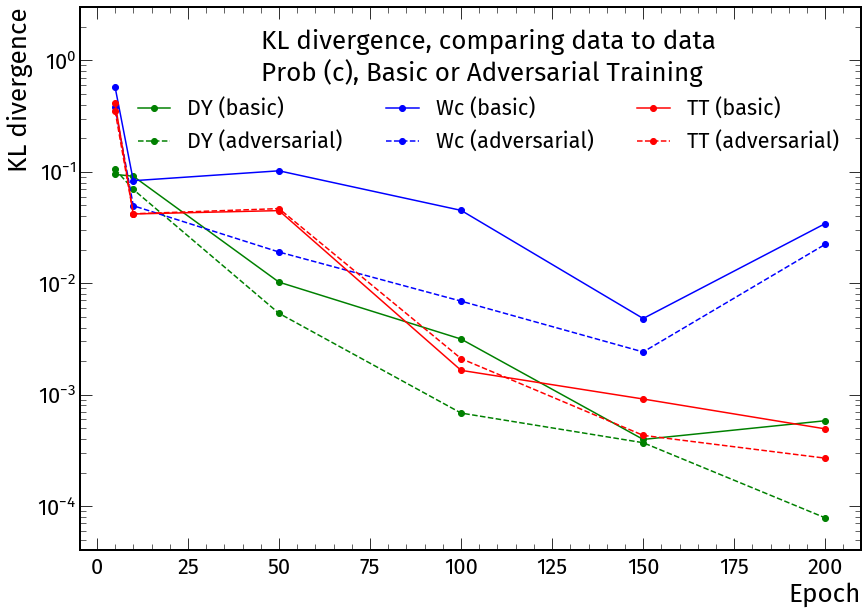

In [164]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,2], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,2],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,2], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,2],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,2], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nProb (c), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=4e-5,top=5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Prob (c), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c_datadata.svg', bbox_inches='tight')

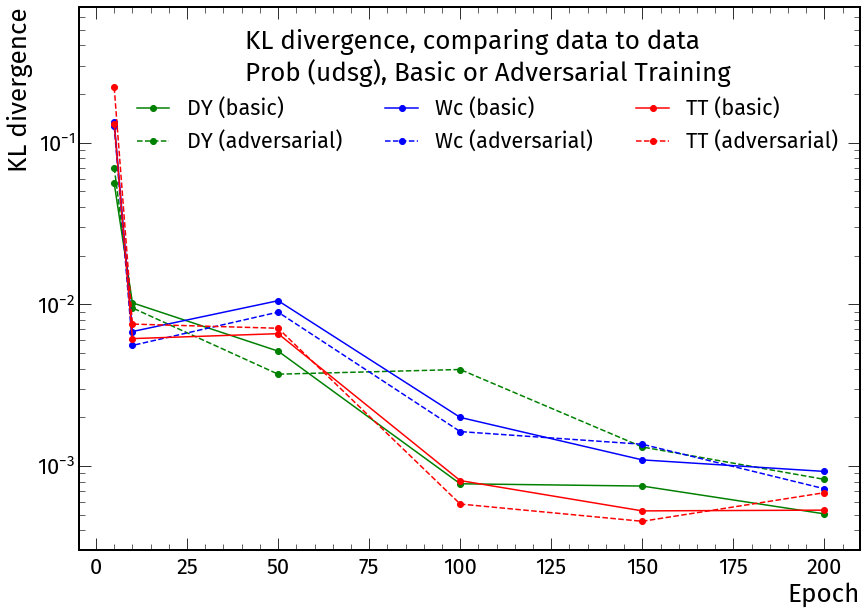

In [162]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,3], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,3],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,3], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,3],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,3], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nProb (udsg), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=3e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n Prob (udsg), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg_datadata.svg', bbox_inches='tight')

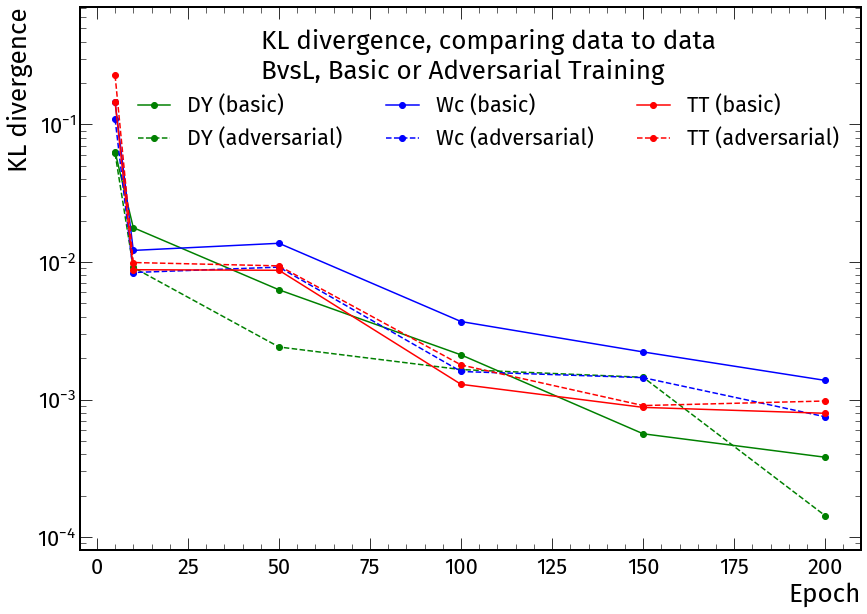

In [161]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,4], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,4],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,4], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,4],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,4], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nBvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=8e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n BvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL_datadata.svg', bbox_inches='tight')

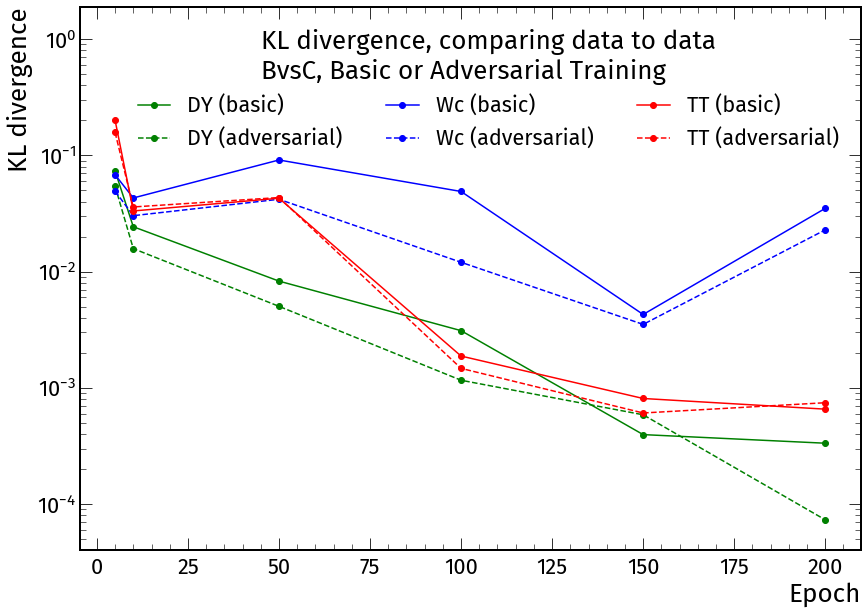

In [160]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,5], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,5],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,5], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,5],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,5], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nBvsC, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=4e-5,top=9*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n BvsC, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC_datadata.svg', bbox_inches='tight')

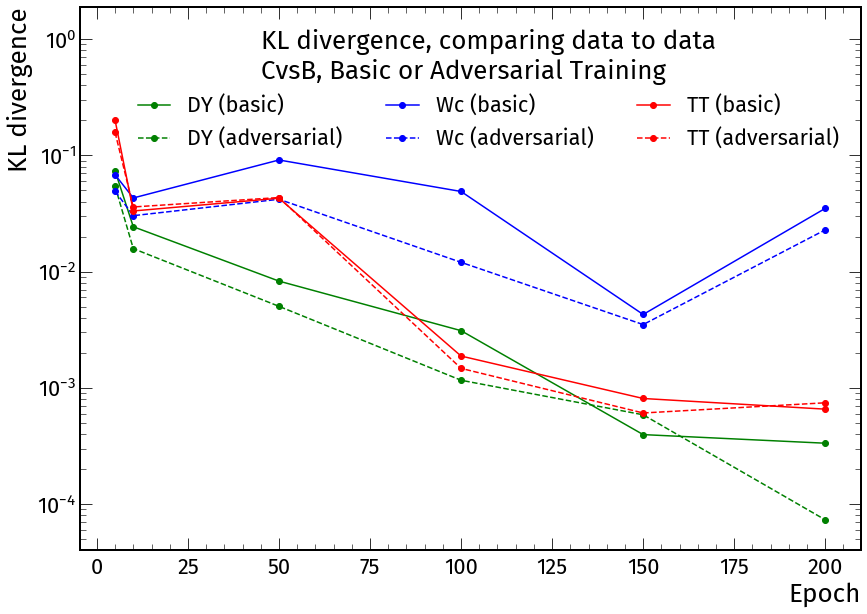

In [158]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,6], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,6],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,6], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,6],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,6], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nCvsB, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=4e-5,top=9*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n CvsB, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB_datadata.svg', bbox_inches='tight')

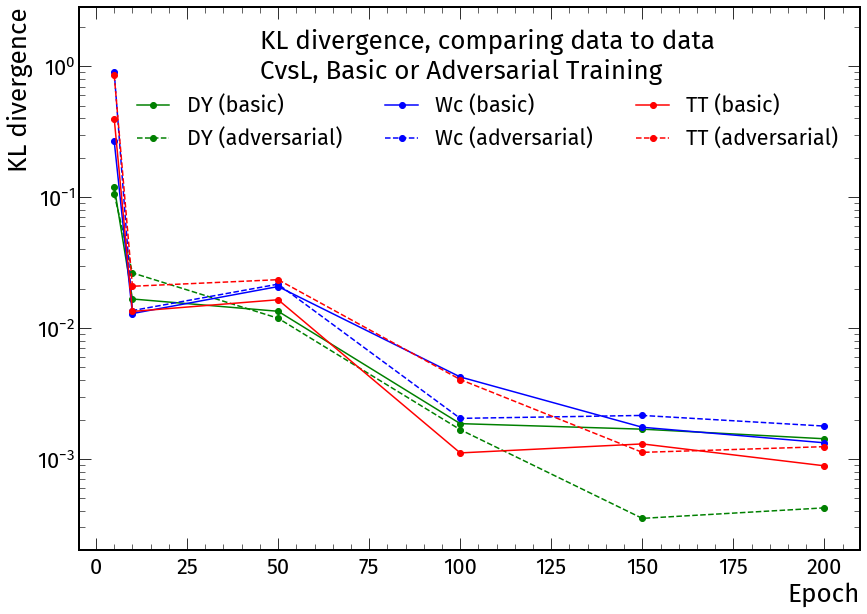

In [156]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,7], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,7],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,7], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,7],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,7], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing data to data\nCvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=2e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing data to data\n CvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsL_datadata.svg', bbox_inches='tight')

***
## Simulation versus Simulation

### Plot KL div for adversarial training

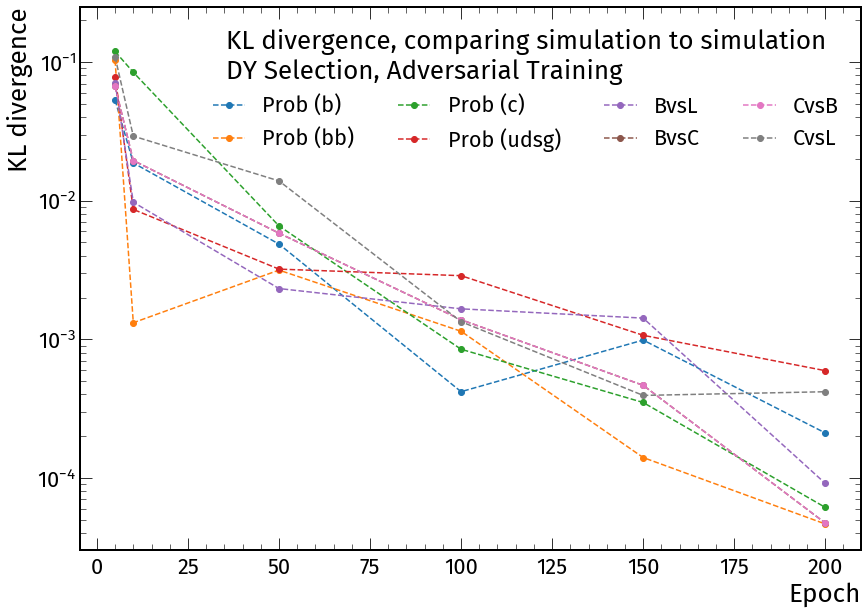

In [176]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nDY Selection, Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(3e-5,2*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n DY Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_DY_simsim.svg', bbox_inches='tight')

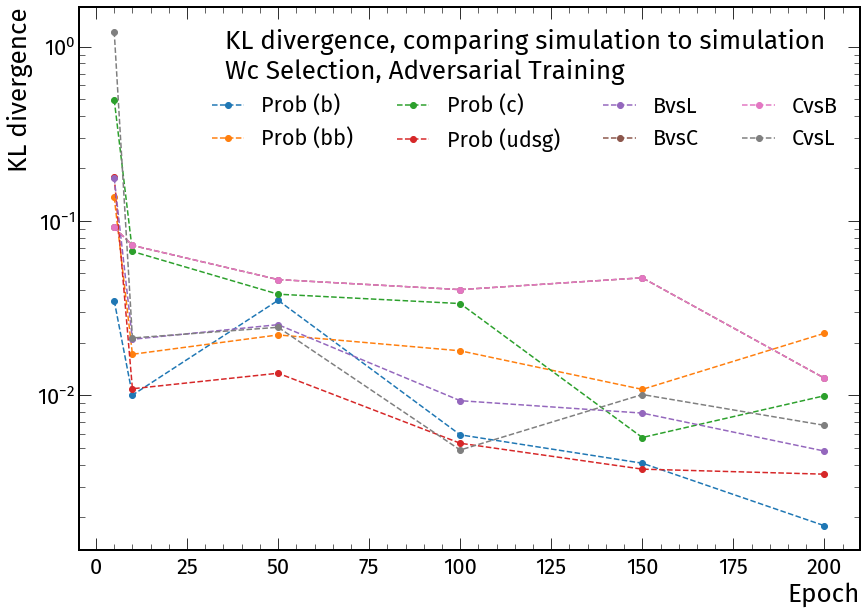

In [154]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nWc Selection, Adversarial Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.05*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Wc Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_Wc_simsim.svg', bbox_inches='tight')

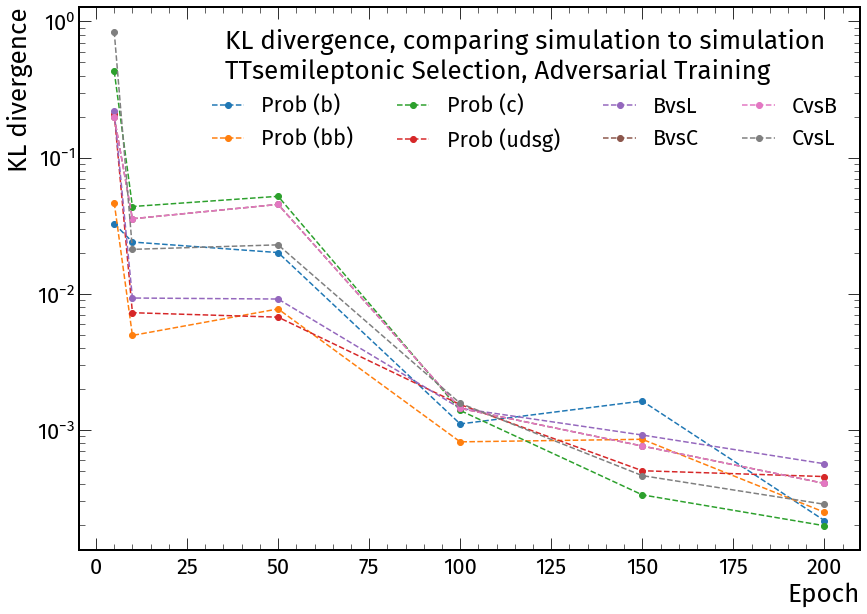

In [152]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],'o--',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],'o--',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],'o--',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],'o--',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],'o--',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],'o--',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],'o--',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],'o--',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nTTsemileptonic Selection, Adversarial Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n TTsemileptonic Selection, Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('KL divergence')
plt.savefig('KL_divergences/adv_TT_simsim.svg', bbox_inches='tight')

### Plot KL div for basic training

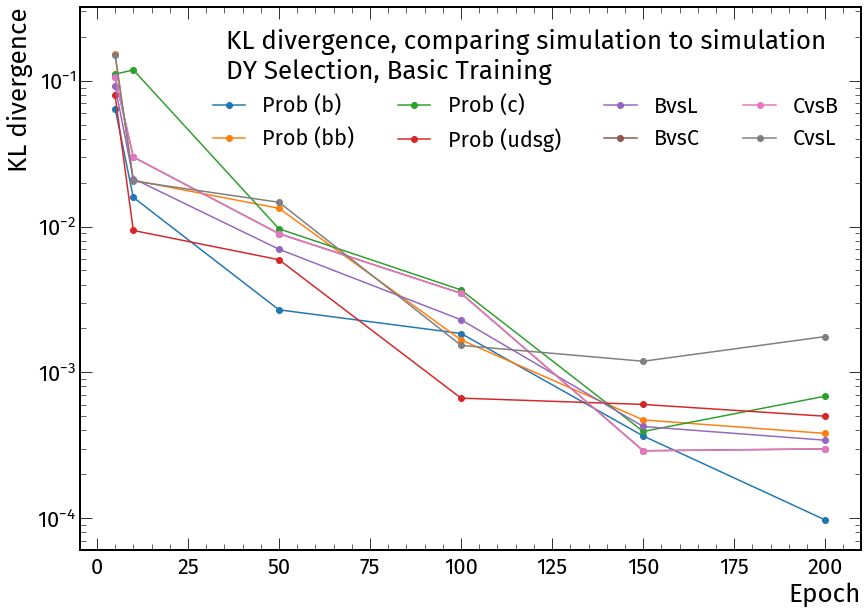

In [150]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nDY Selection, Basic Training')
y_lims = ax.get_ylim()
ax.set_ylim(6e-5,2*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n DY Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_DY_simsim.svg', bbox_inches='tight')

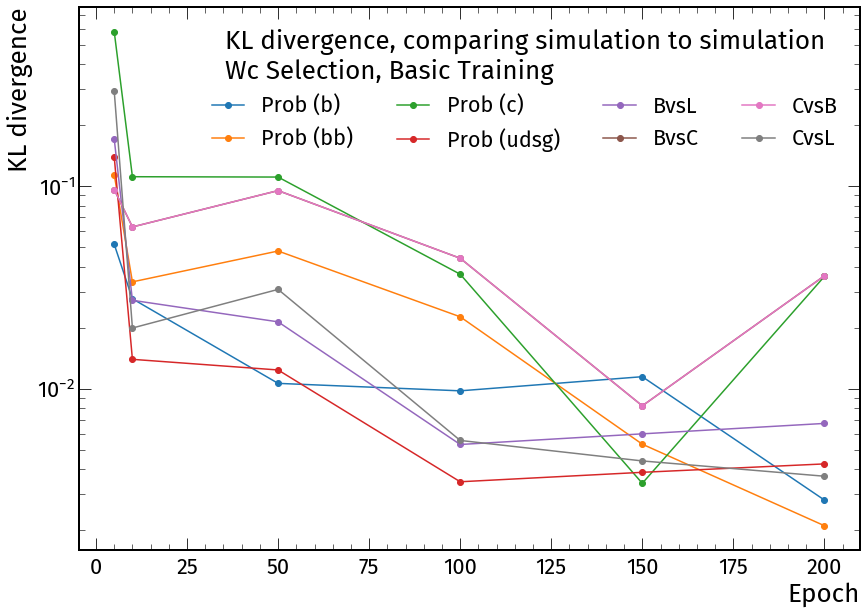

In [145]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nWc Selection, Basic Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Wc Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_Wc_simsim.svg', bbox_inches='tight')

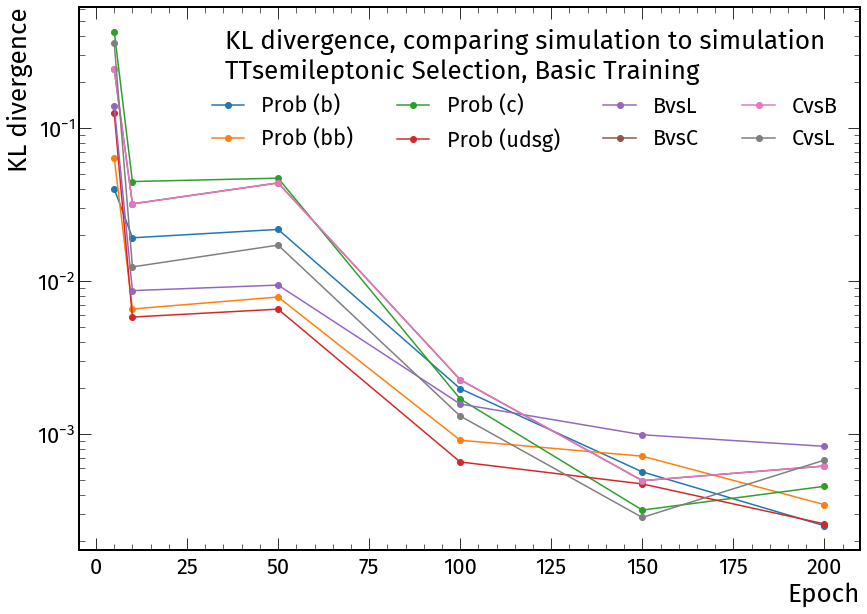

In [144]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0],'o-',label='Prob (b)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1],'o-',label='Prob (bb)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2],'o-',label='Prob (c)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3],'o-',label='Prob (udsg)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4],'o-',label='BvsL')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5],'o-',label='BvsC')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6],'o-',label='CvsB')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7],'o-',label='CvsL')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=4,title='KL divergence, comparing simulation to simulation\nTTsemileptonic Selection, Basic Training')
#y_lims = ax.get_ylim()
#ax.set_ylim(min(y_lims),1.15*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n TTsemileptonic Selection, Basic Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/basic_TT_simsim.svg', bbox_inches='tight')

### Compare KL divergence for basic or adversarial training

(-0.0031272984659550546, 0.06780963678737466)


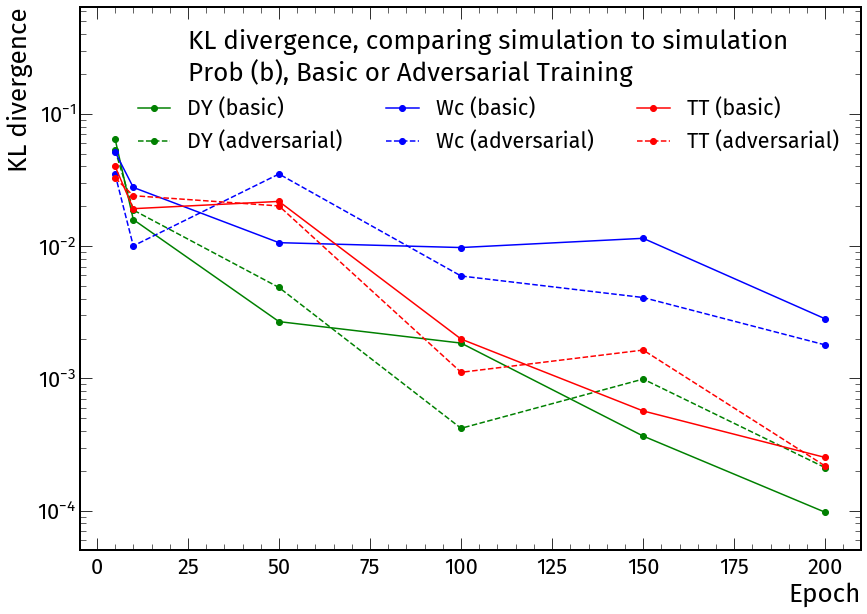

In [135]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,0], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,0],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,0], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,0],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nProb (b), Basic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=5e-5,top=9.5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Prob (b), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b_simsim.svg', bbox_inches='tight')

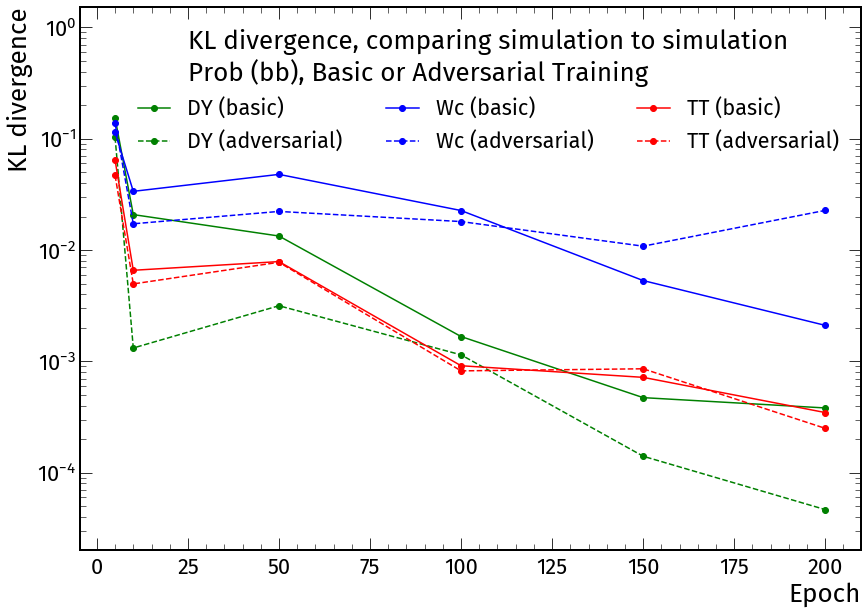

In [136]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,1], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,1],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,1], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,1],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nProb (bb), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=2e-5,top=9.5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Prob (bb), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb_simsim.svg', bbox_inches='tight')

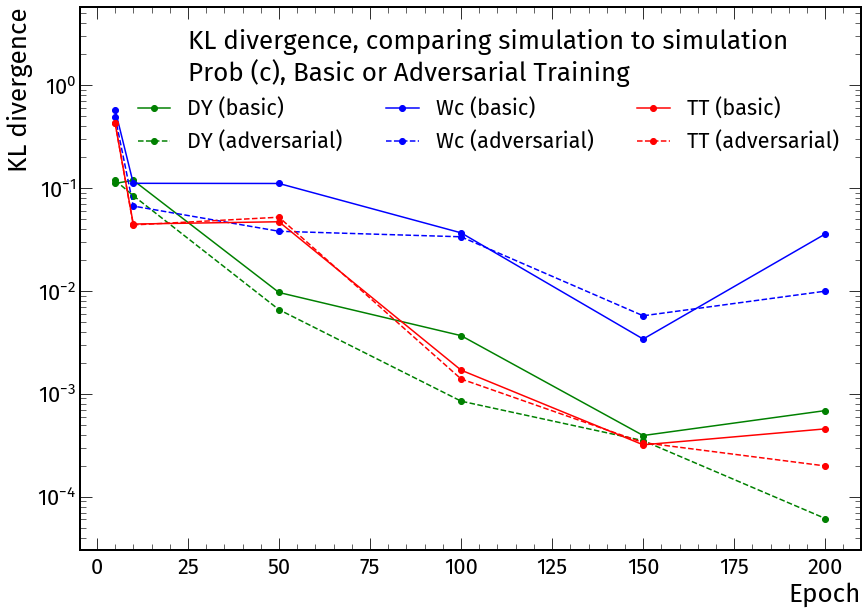

In [137]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,2], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,2],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,2], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,2],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nProb (c), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=3e-5,top=9.5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Prob (c), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c_simsim.svg', bbox_inches='tight')

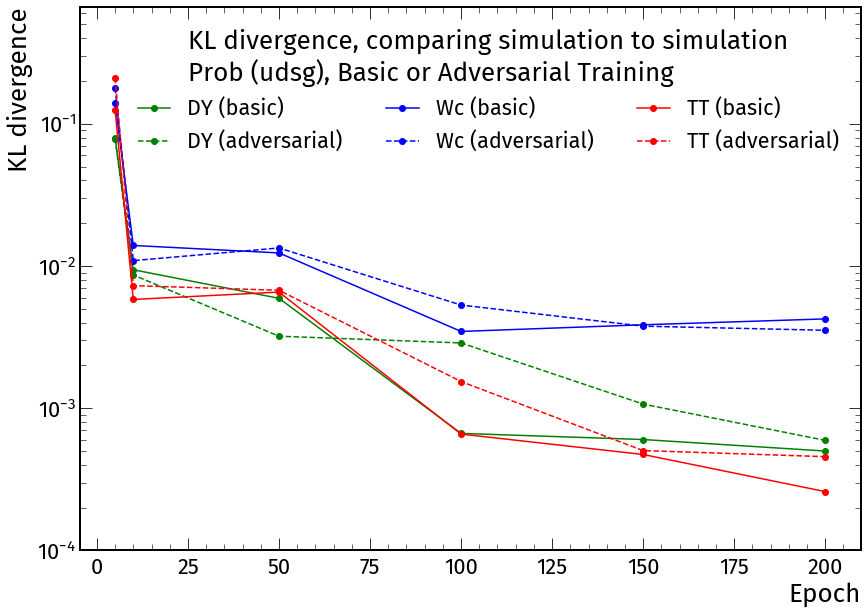

In [138]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,3], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,3],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,3], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,3],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nProb (udsg), Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=1e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n Prob (udsg), Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg_simsim.svg', bbox_inches='tight')

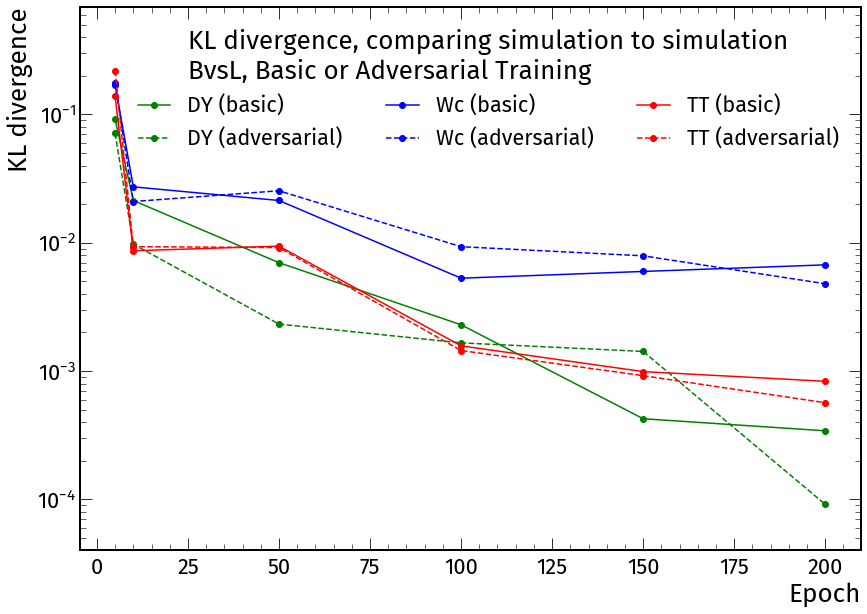

In [139]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,4], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,4],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,4], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,4],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nBvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=4e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n BvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL_simsim.svg', bbox_inches='tight')

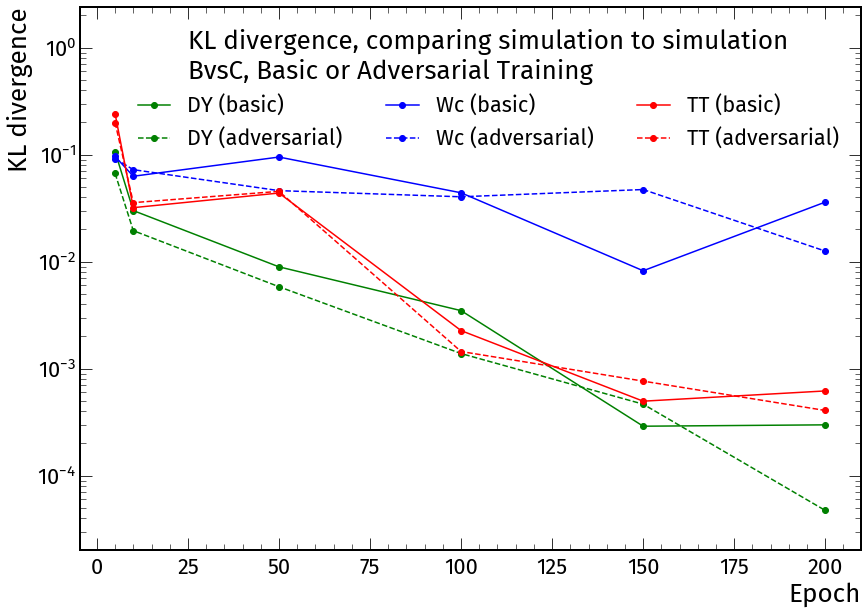

In [140]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,5], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,5],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,5], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,5],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nBvsC, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=2e-5,top=9.5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n BvsC, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC_simsim.svg', bbox_inches='tight')

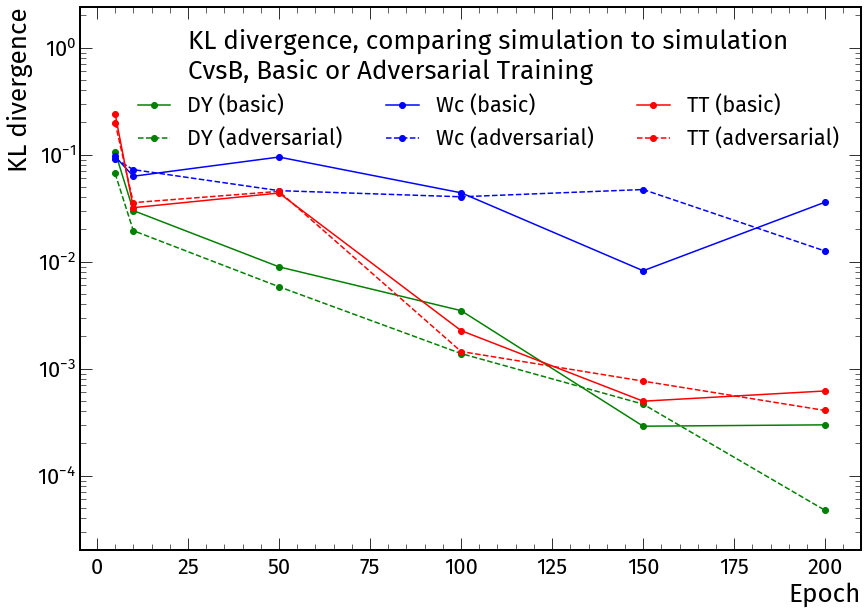

In [141]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,6], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,6],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,6], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,6],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nCvsB, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=2e-5,top=9.5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n CvsB, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB_simsim.svg', bbox_inches='tight')

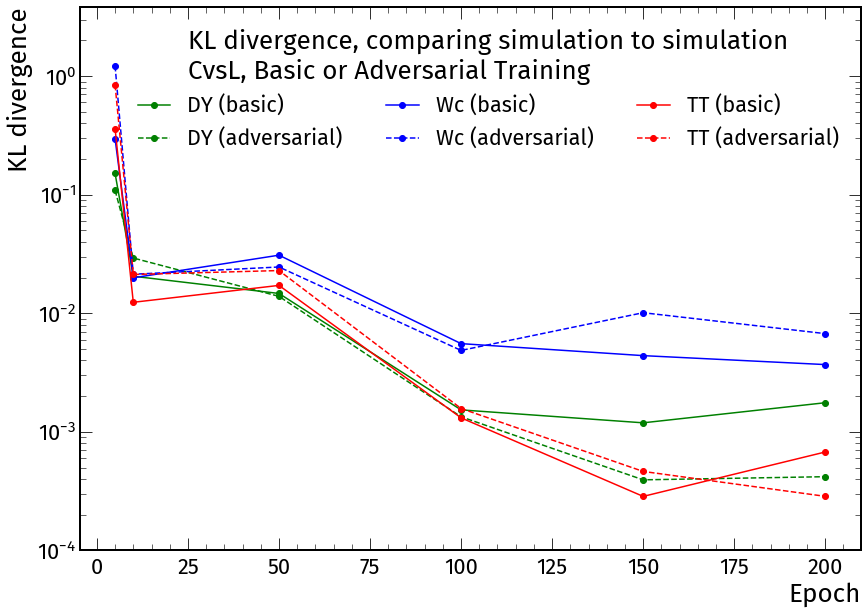

In [142]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,7], 'o-g', label='DY (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,7],  'o--g', label='DY (adversarial)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,7], 'o-b', label='Wc (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,7],  'o--b', label='Wc (adversarial)',linestyle='dashed')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-r', label='TT (basic)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, comparing simulation to simulation\nCvsL, Basic or Adversarial Training')
y_lims = ax.get_ylim()
ax.set_ylim(bottom=1e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, comparing simulation to simulation\n CvsL, Basic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsL_simsim.svg', bbox_inches='tight')

***
## Compare everything (split by selection, variable)

### Prob (b)

#### DY

(-0.0031272984659550546, 0.06780963678737466)


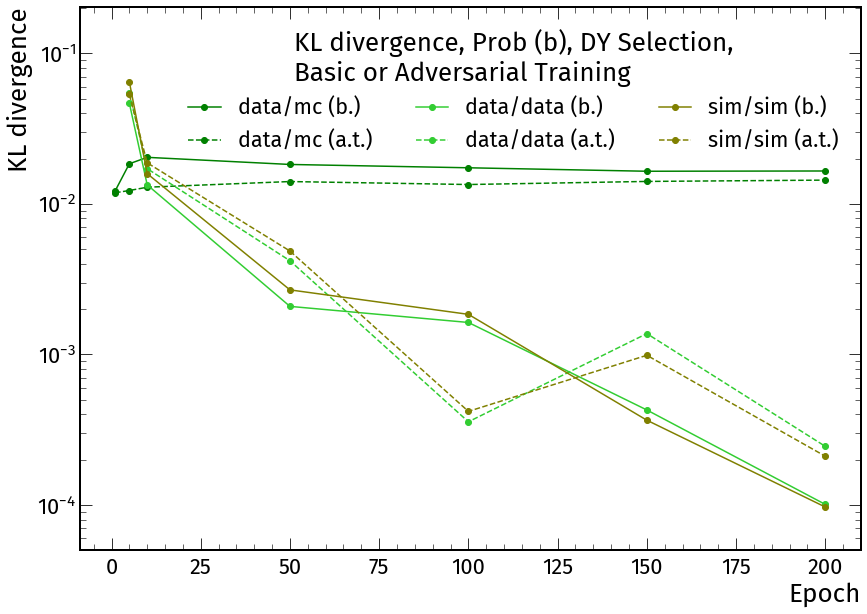

In [118]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,0], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,0],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,0], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,0],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,0], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,0],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,0], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,0],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (b), DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=5e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (b), DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b_compare_DY.svg', bbox_inches='tight')

### Prob (bb)

#### DY

(-0.007621777397197941, 0.16108134766806964)


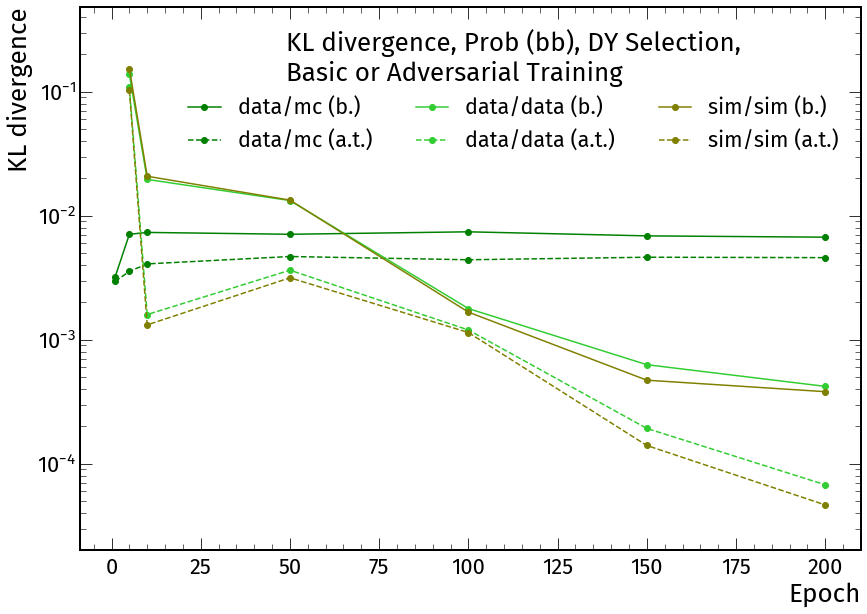

In [117]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,1], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,1],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,1], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,1],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,1], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,1],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,1], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,1],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (bb), DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (bb), DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb_compare_DY.svg', bbox_inches='tight')

### Prob (c)

#### DY

(-0.0058949703496348465, 0.12514306571798145)


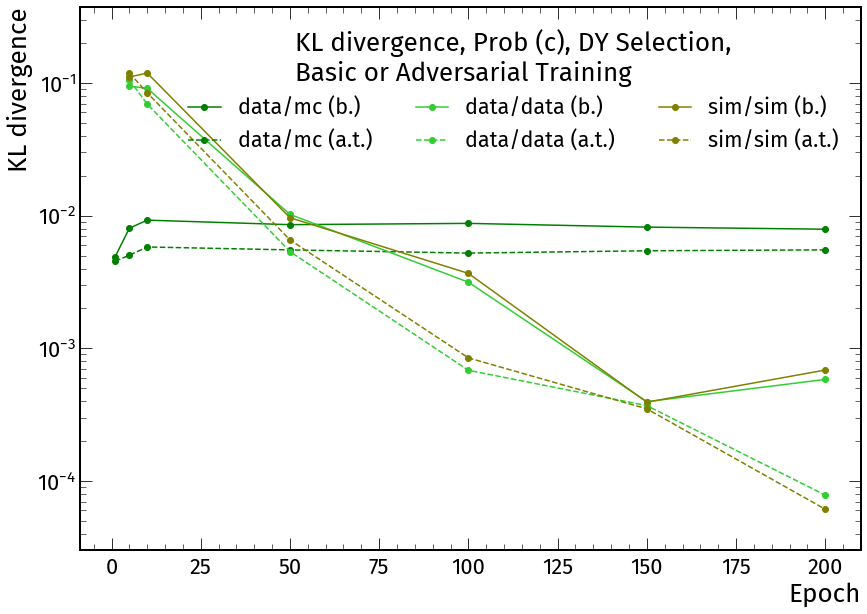

In [116]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,2], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,2],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,2], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,2],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,2], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,2],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,2], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,2],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (c), DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=3e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (c), DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c_compare_DY.svg', bbox_inches='tight')

### Prob (udsg)

#### DY

(-0.0034464781116626333, 0.08337480709372241)


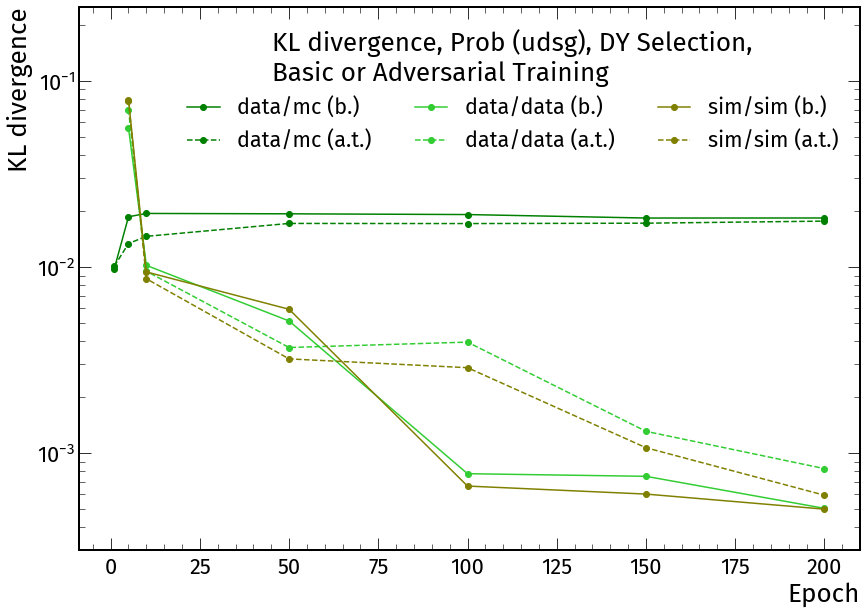

In [115]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,3], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,3],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,3], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,3],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,3], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,3],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,3], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,3],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (udsg), DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=3e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (udsg), DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg_compare_DY.svg', bbox_inches='tight')

### BvsL

#### DY

(-0.004503208094736282, 0.09657721884496617)


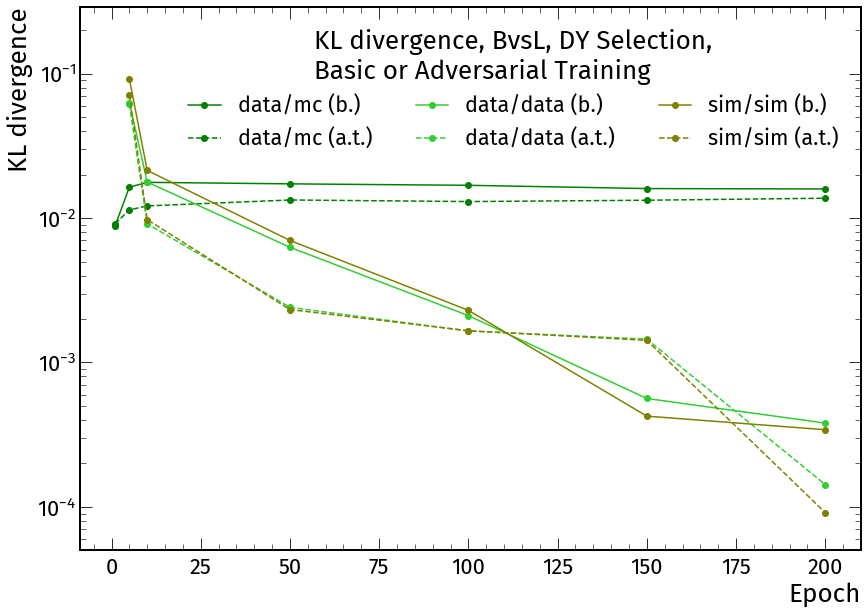

In [114]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,4], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,4],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,4], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,4],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,4], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,4],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,4], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,4],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsL, DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=5e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsL, DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL_compare_DY.svg', bbox_inches='tight')

### BvsC

#### DY

(-0.005276512772339279, 0.1118467430260325)


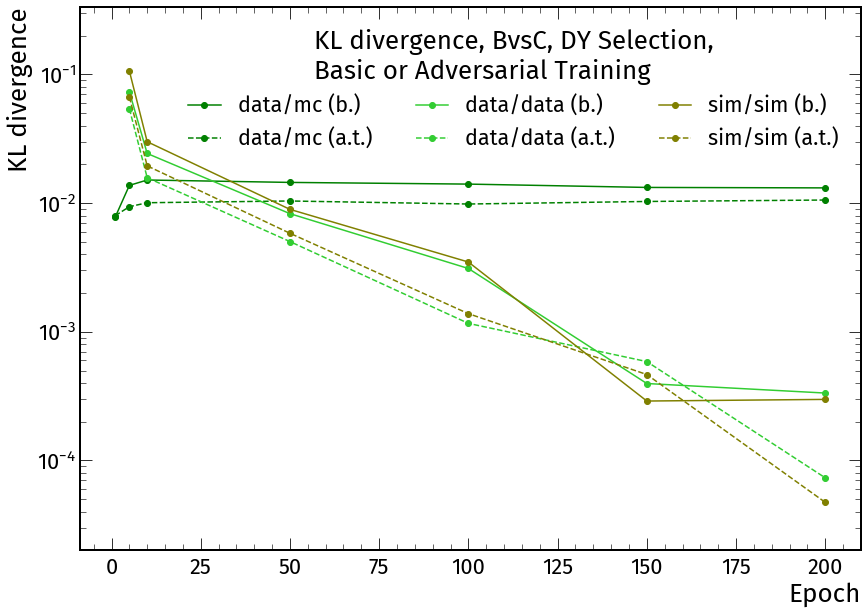

In [113]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,5], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,5],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,5], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,5],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,5], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,5],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,5], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,5],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsC, DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsC, DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC_compare_DY.svg', bbox_inches='tight')

### CvsB

#### DY

(-0.005276527095057853, 0.11184704380313161)


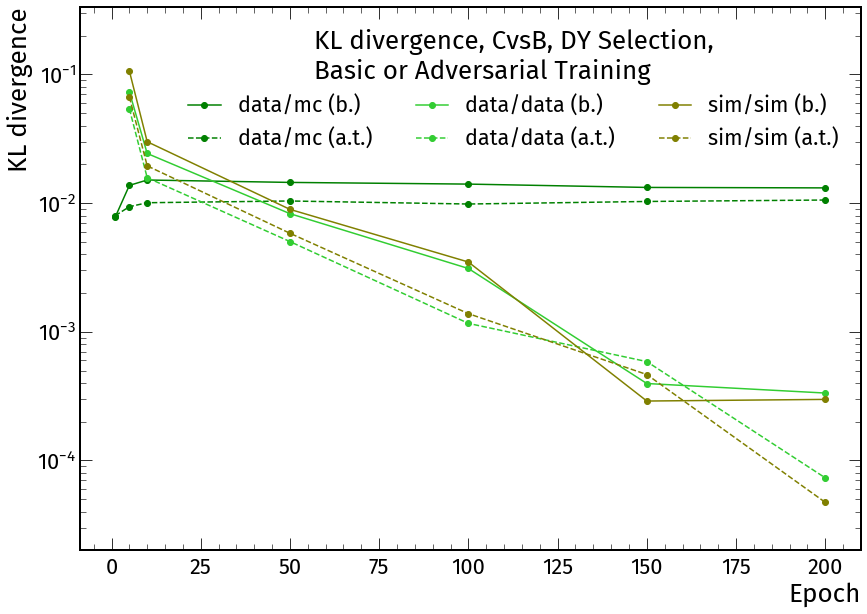

In [112]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,6], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,6],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,6], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,6],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,6], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,6],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,6], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,6],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsB, DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsB, DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB_compare_DY.svg', bbox_inches='tight')

### CvsL

#### DY

(-0.00718729899783593, 0.15866772157165746)


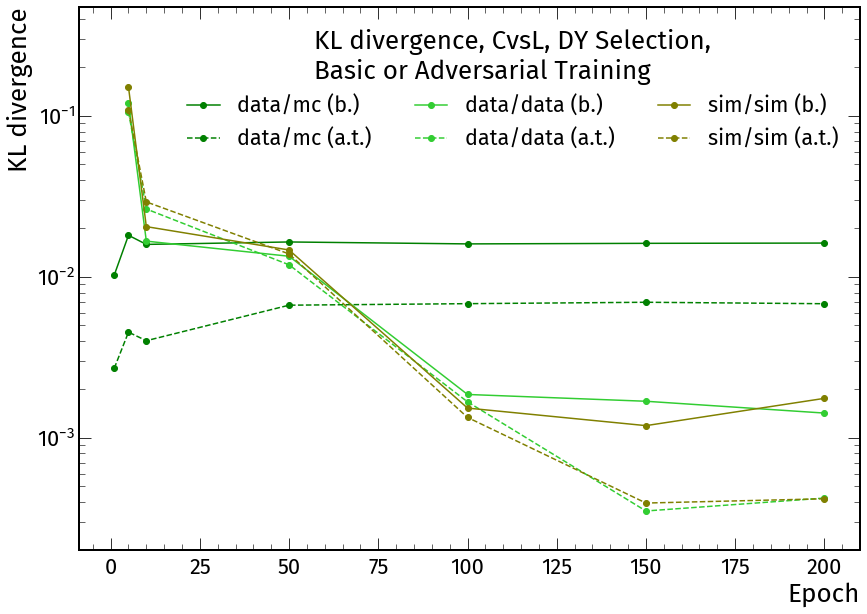

In [111]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_DY[:,7], 'o-g', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_DY[:,7],  'o--g', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_datadata[:,7], 'o-',color='limegreen', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_datadata[:,7],  'o--',color='limegreen', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_DY_simsim[:,7], 'o-',color='olive', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_DY_simsim[:,7],  'o--',color='olive', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,7], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,7],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsL, DY Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsL, DY Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsL_compare_DY.svg', bbox_inches='tight')

### Prob (b)

#### Wc

(-0.0007009418459910548, 0.05407909625483055)


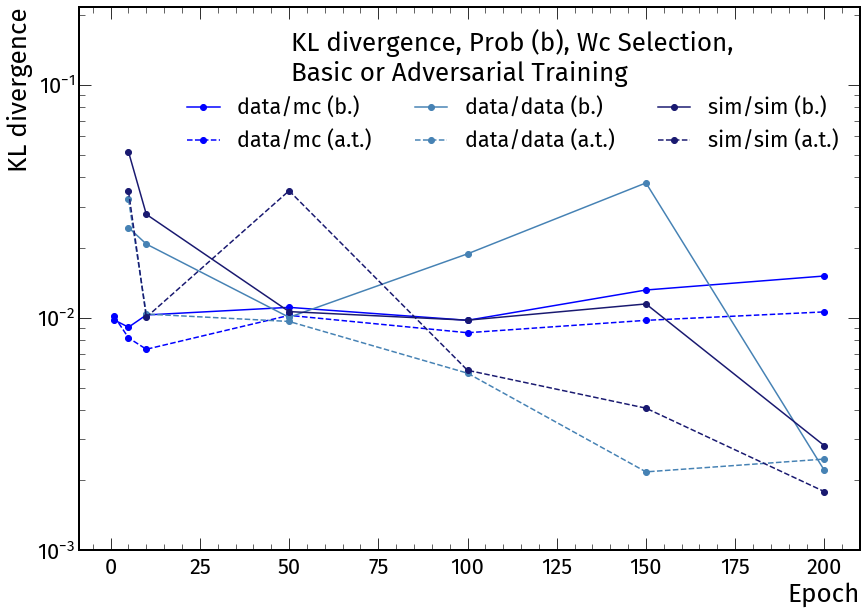

In [110]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,0], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,0],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,0], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,0],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,0], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,0],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,0], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,0],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (b), Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-3,top=4*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (b), Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b_compare_Wc.svg', bbox_inches='tight')

### Prob (bb)

#### Wc

(-0.004985728282572594, 0.14371963123870302)


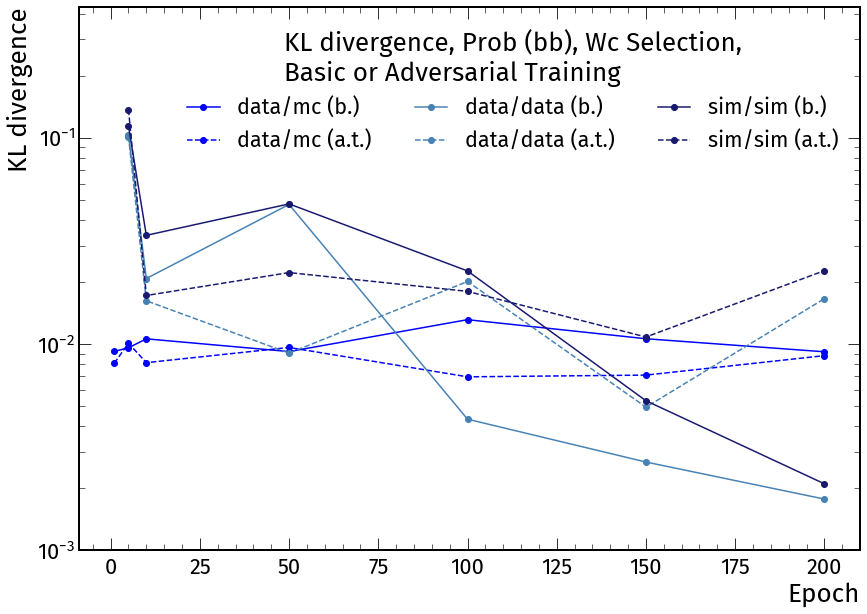

In [107]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,1], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,1],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,1], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,1],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,1], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,1],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,1], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,1],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (bb), Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-3,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (bb), Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb_compare_Wc.svg', bbox_inches='tight')

### Prob (c)

#### Wc

(-0.026453403901022843, 0.608686300887843)


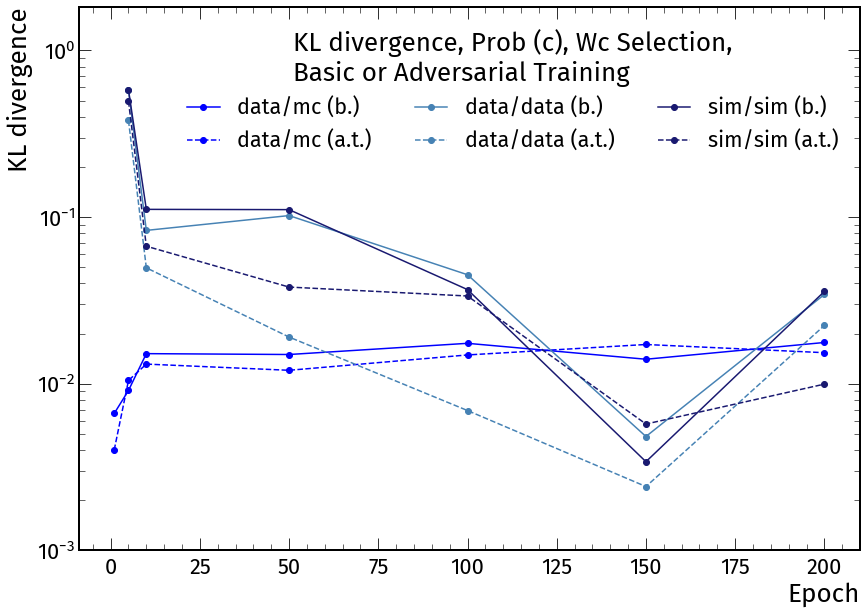

In [105]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,2], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,2],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,2], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,2],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,2], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,2],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,2], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,2],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (c), Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-3,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (c), Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c_compare_Wc.svg', bbox_inches='tight')

### Prob (udsg)

#### Wc

(-0.008219104057333518, 0.18848842263149065)


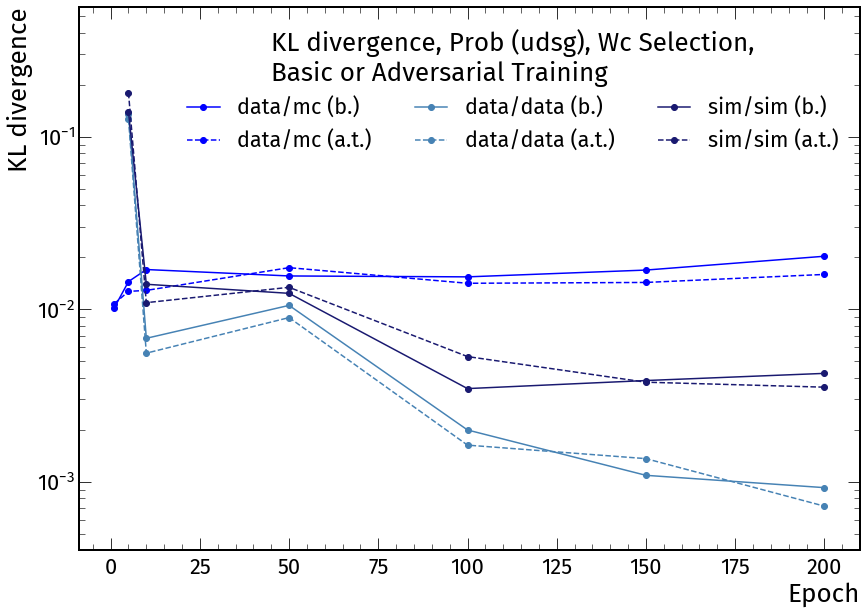

In [104]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,3], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,3],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,3], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,3],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,3], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,3],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,3], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,3],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (udsg), Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=4e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (udsg), Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg_compare_Wc.svg', bbox_inches='tight')

### BvsL

#### Wc

(-0.008035509694636926, 0.18522148459635865)


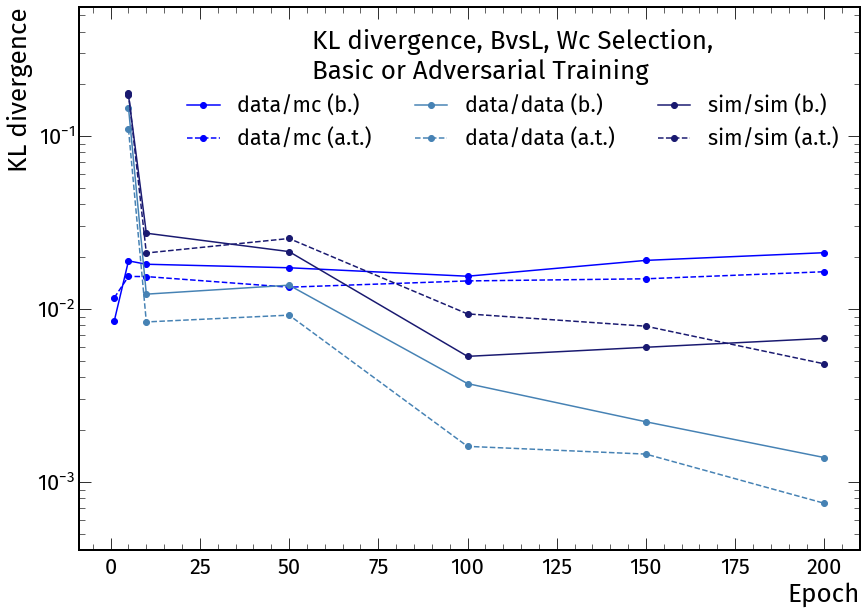

In [103]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,4], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,4],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,4], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,4],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,4], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,4],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,4], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,4],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsL, Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=4e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsL, Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL_compare_Wc.svg', bbox_inches='tight')

### BvsC

#### Wc

(-0.0011182699409626319, 0.10081881712937851)


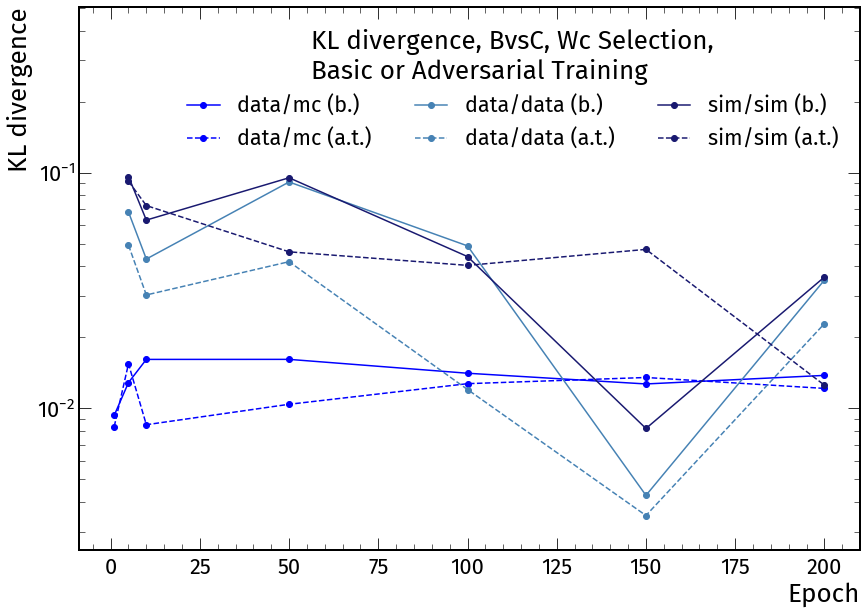

In [102]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,5], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,5],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,5], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,5],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,5], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,5],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,5], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,5],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsC, Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2.5e-3,top=5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsC, Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC_compare_Wc.svg', bbox_inches='tight')

### CvsB

#### Wc

(-0.0011311201449146044, 0.10081942904385204)


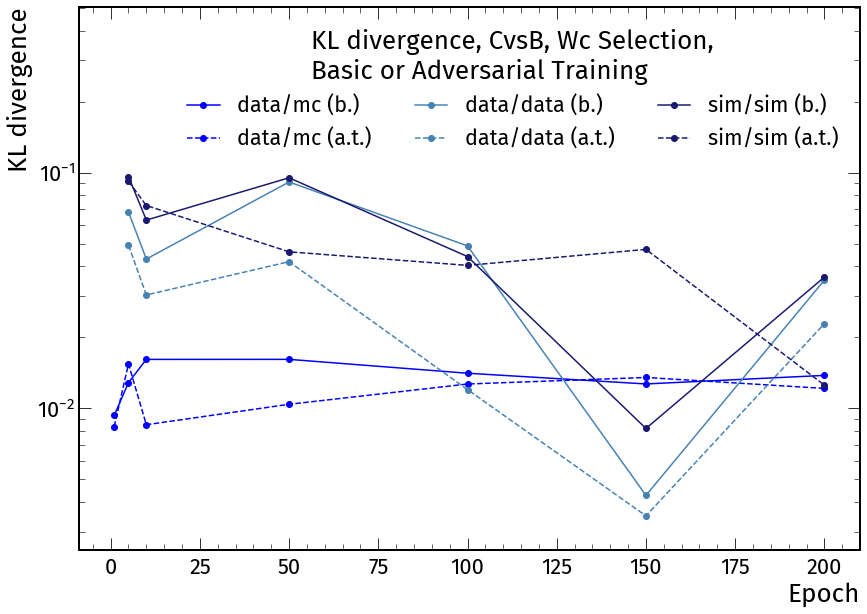

In [100]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,6], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,6],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,6], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,6],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,6], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,6],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,6], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,6],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsB, Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2.5e-3,top=5*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsB, Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB_compare_Wc.svg', bbox_inches='tight')

### CvsL

#### Wc

(-0.05957493161994797, 1.280307211144029)


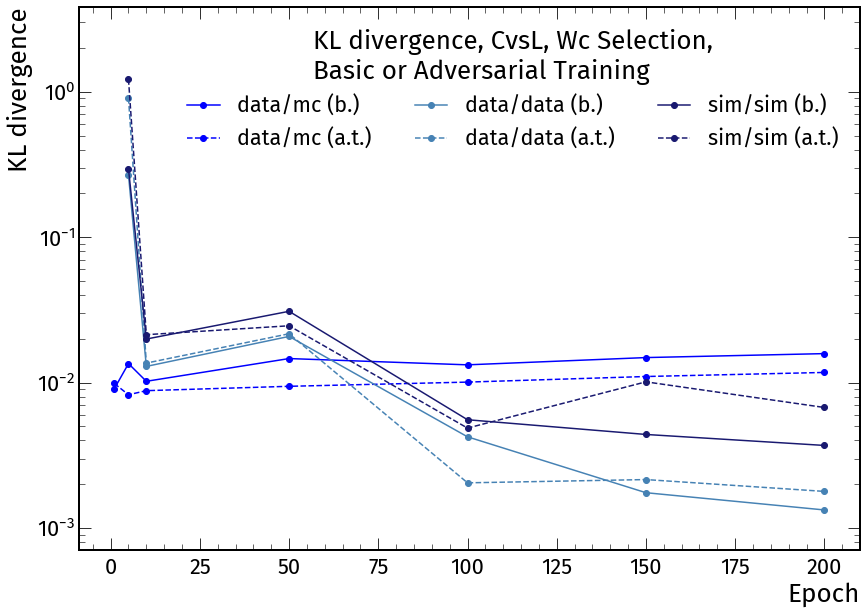

In [93]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_Wc[:,7], 'o-b', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_Wc[:,7],  'o--b', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_datadata[:,7], 'o-',color='steelblue', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_datadata[:,7],  'o--',color='steelblue', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,7], 'o-',color='midnightblue', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,7],  'o--',color='midnightblue', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_Wc_simsim[:,7], 'o-b', label='Wc (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_Wc_simsim[:,7],  'o--b', label='Wc (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsL, Wc Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=7e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsL, Wc Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsL_compare_Wc.svg', bbox_inches='tight')

### Prob (b)

#### TT

(-0.0017767713422636002, 0.04208782586567845)


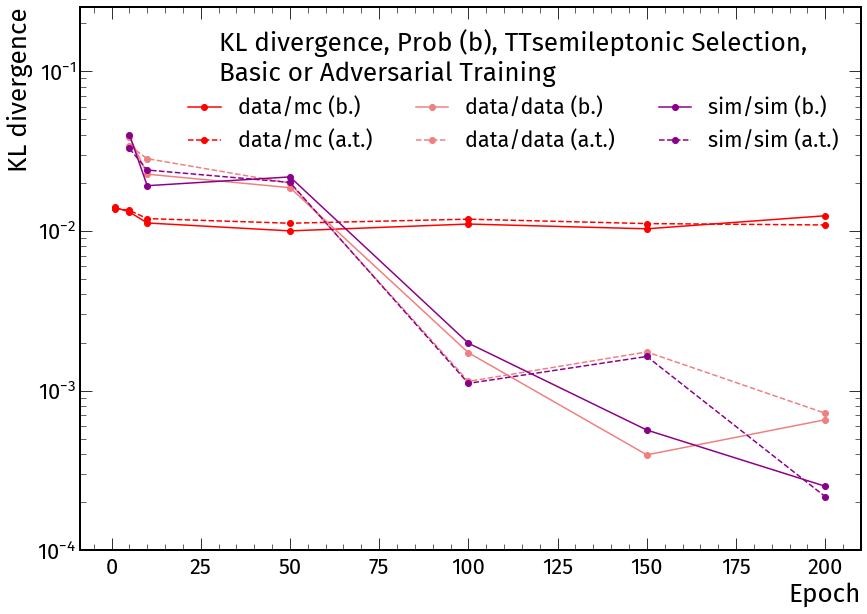

In [96]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,0], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,0],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,0], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,0],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,0], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,0],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (b), TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-4,top=6*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (b), TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/b_compare_TT.svg', bbox_inches='tight')

### Prob (bb)

#### TT

(-0.002939337941885853, 0.06722246341037397)


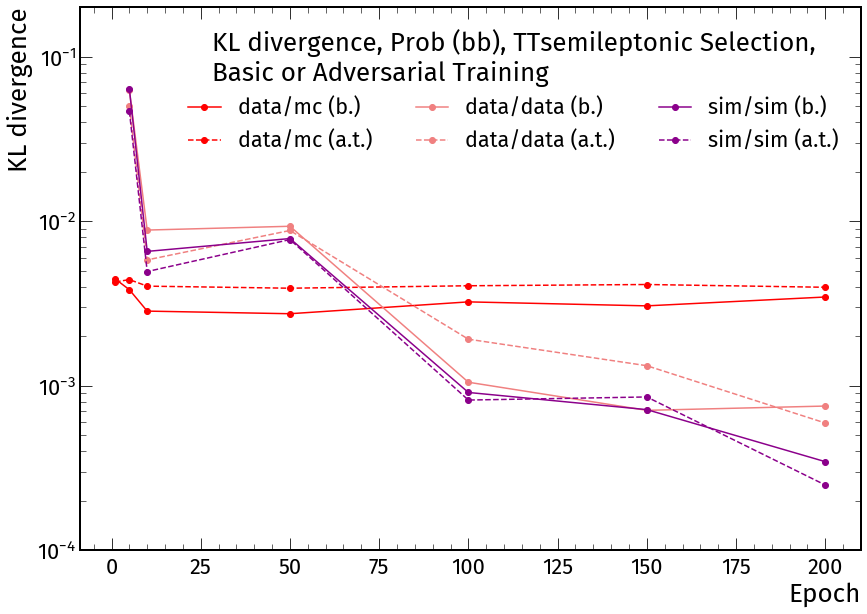

In [91]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,1], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,1],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,1], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,1],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,1], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,1],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (bb), TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (bb), TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/bb_compare_TT.svg', bbox_inches='tight')

### Prob (c)

#### TT

(-0.021365275462264383, 0.4530455693696144)


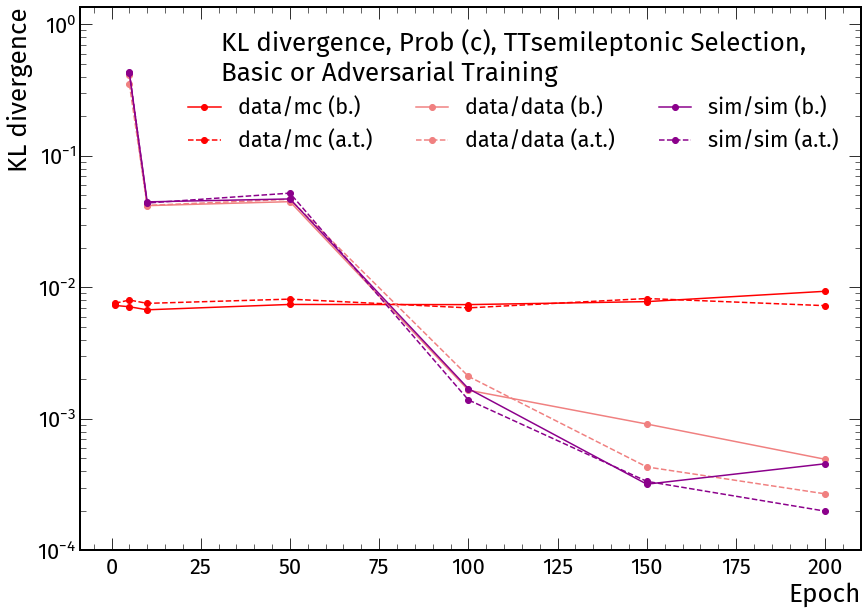

In [90]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,2], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,2],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,2], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,2],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,2], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,2],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (c), TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (c), TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/c_compare_TT.svg', bbox_inches='tight')

### Prob (udsg)

#### TT

(-0.010718596760796563, 0.23079169997005644)


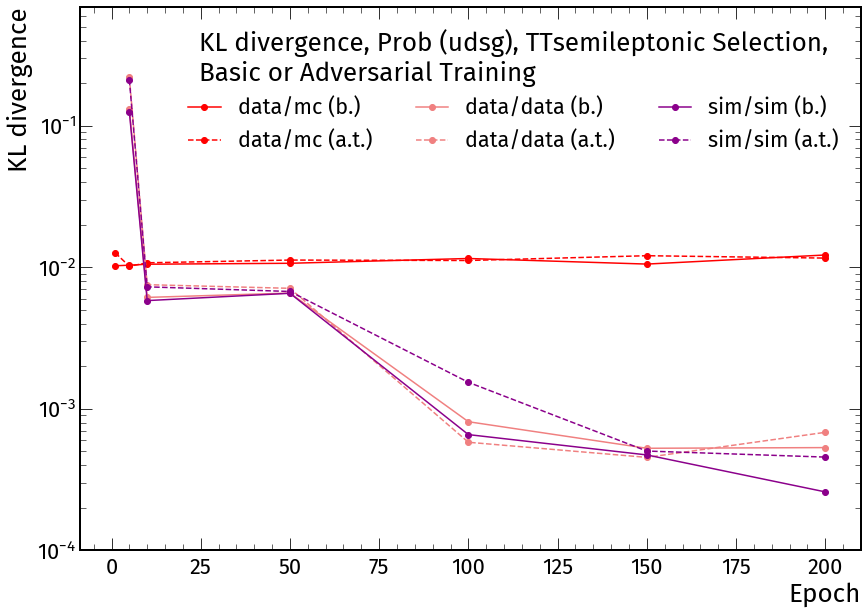

In [89]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,3], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,3],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,3], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,3],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,3], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,3],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, Prob (udsg), TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=1e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, Prob (udsg), TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/udsg_compare_TT.svg', bbox_inches='tight')

### BvsL

#### TT

(-0.010752501640408103, 0.23827088102679006)


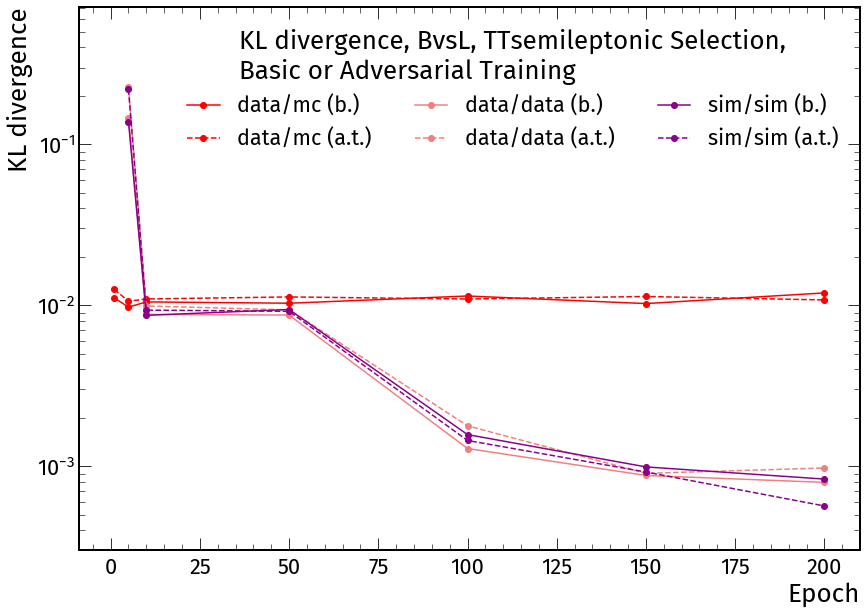

In [87]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,4], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,4],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,4], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,4],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,4], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,4],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsL, TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=3e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsL, TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsL_compare_TT.svg', bbox_inches='tight')

### BvsC

#### TT

(-0.011650441963235565, 0.2536027775550668)


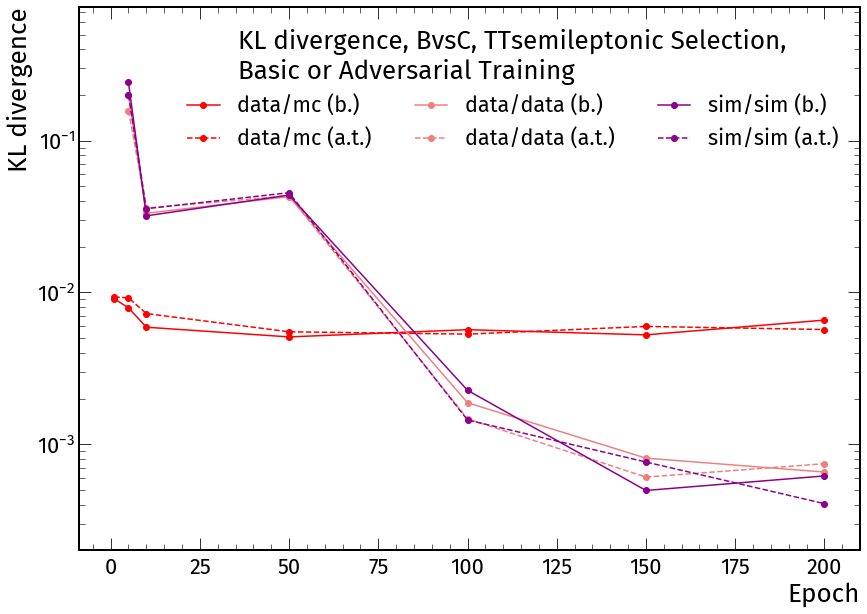

In [86]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,5], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,5],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,5], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,5],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,5], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,5],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, BvsC, TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, BvsC, TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/BvsC_compare_TT.svg', bbox_inches='tight')

### CvsB

#### TT

(-0.011650542546033763, 0.25360286934192483)


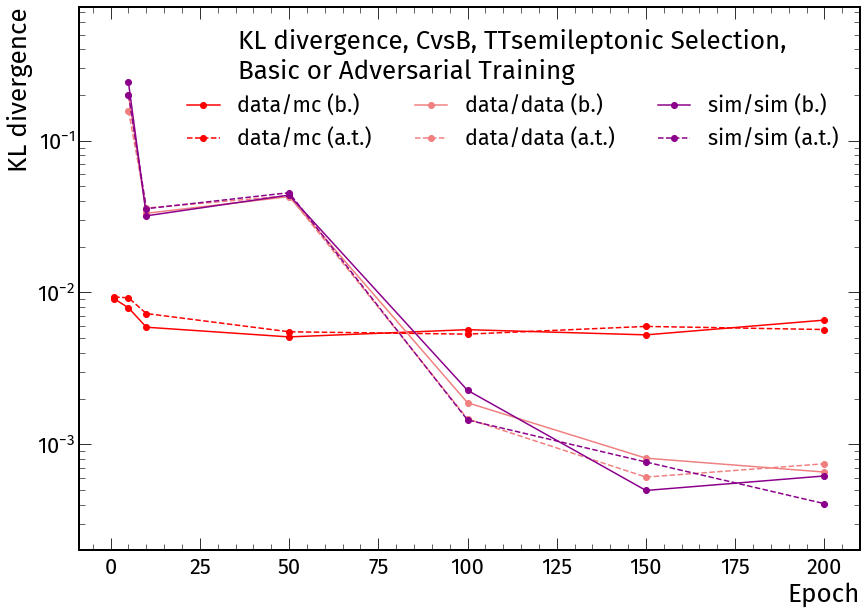

In [85]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,6], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,6],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,6], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,6],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,6], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,6],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsB, TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=2e-4,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsB, TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
plt.savefig('KL_divergences/CvsB_compare_TT.svg', bbox_inches='tight')

### CvsL

#### TT

(-0.042438761479533724, 0.8974954464774962)


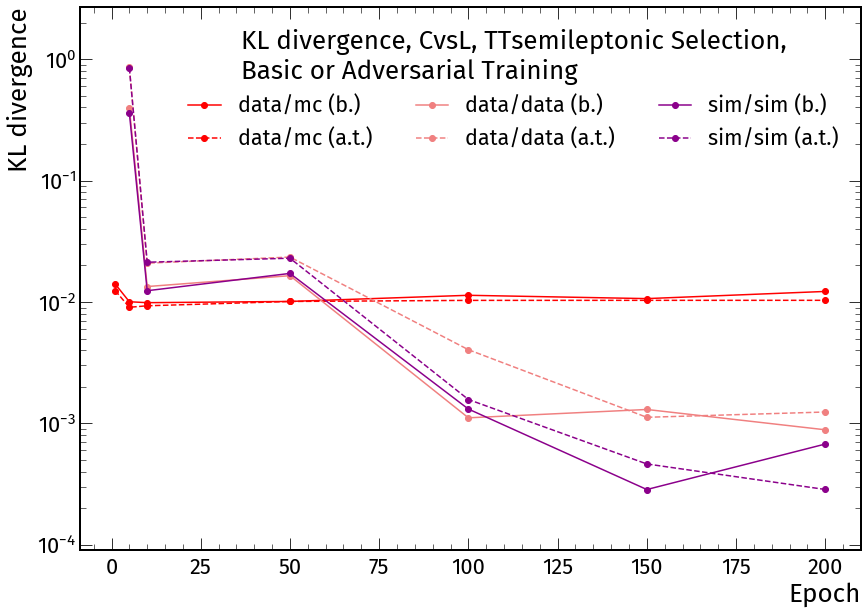

In [218]:
fig, ax = plt.subplots(1,figsize=[14,10])
ax.plot(epochs, kl_divs_all_basic_TT[:,7], 'o-r', label='data/mc (b.)')
ax.plot(epochs, kl_divs_all_adv_TT[:,7],  'o--r', label='data/mc (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_datadata[:,7], 'o-',color='lightcoral', label='data/data (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_datadata[:,7],  'o--',color='lightcoral', label='data/data (a.t.)')
ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-',color='darkmagenta', label='sim/sim (b.)')
ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--',color='darkmagenta', label='sim/sim (a.t.)')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#ax.plot(epochs[1:], kl_divs_all_basic_TT_simsim[:,7], 'o-r', label='TT (basic)')
#ax.plot(epochs[1:], kl_divs_all_adv_TT_simsim[:,7],  'o--r', label='TT (adversarial)',linestyle='dashed')
#plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.legend(ncol=3,loc='upper right',title='KL divergence, CvsL, TTsemileptonic Selection,\nBasic or Adversarial Training')
y_lims = ax.get_ylim()
print(y_lims)
ax.set_ylim(bottom=9e-5,top=3*max(y_lims))
ax.set_yscale('log')
#fig.suptitle('KL divergence, CvsL, TTsemileptonic Selection,\nBasic or Adversarial Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
#plt.grid(which='minor', alpha=0.9)
#plt.grid(which='major', alpha=1, color='black')
plt.savefig('KL_divergences/CvsL_compare_TT.svg', bbox_inches='tight')

In [219]:
!tar czf KL_divs_20210716.tar.gz KL_divergences/*.svg